# Projekt zespołowy 
### **Badanie czynników wpływających na długość życia na podstawie danych z WHO**
Monika Kusiak (307410)  
Maciej Dragun (298748)

In [ ]:
import pandas as pd
import numpy as np
from numpy import NaN

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew

from itertools import product

from math import log, sqrt, log2, log10

from itertools import product

In [ ]:
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 284

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### **Wczytanie danych**

---



In [ ]:
FILE_NAME = "LifeExpectancyData.csv"
FORMATTED_OUTPUT_FILE_NAME = "Formatted.csv"
COLUMNS_TO_EXCLUDE = ["Country", "Year"]

COLUMNS_EXPLANATIONS = {
	"Country": "Country - removed from analysis",
	"Year": "Year of measurements - removed from analysis",
	"Status": "Developed (1) or Developing (0) status",
	"Life expectancy": "Life Expectancy in age",
	"Adult Mortality": "Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)",
	"infant deaths": "Number of Infant Deaths per 1000 population",
	"Alcohol": "Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)",
	"percentage expenditure": "Expenditure on health as a percentage of Gross Domestic Product per capita(%)",
	"Hepatitis B": "Hepatitis B (HepB) immunization coverage among 1-year-olds (%)",
	"Measles": "Measles - number of reported cases per 1000 population",
	"BMI": "Average Body Mass Index of entire population",
	"under-five deaths": "Number of under-five deaths per 1000 population",
	"Polio": "Polio (Pol3) immunization coverage among 1-year-olds (%)",
	"Total expenditure": "General government expenditure on health as a percentage of total government expenditure (%)",
	"Diphtheria": "Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)",
	"HIV/AIDS": "Deaths per 1 000 live births HIV/AIDS (0-4 years)",
	"GDP": "Gross Domestic Product per capita (in USD)",
	"Population": "Population of the country",
	"thinness 1-19 years": "Prevalence of thinness among children and adolescents for Age 10 to 19 (%)",
	"thinness 5-9 years": "Prevalence of thinness among children for Age 5 to 9(%)",
	"Income composition of resources": "Human Development Index in terms of income composition of resources (index ranging from 0 to 1)",
	"Schooling": "Number of years of Schooling(years)"
}

COLUMN_UNITS = {
	"Adult Mortality": "[per 1000]",
	"infant deaths": "[per 1000]",
	"Alcohol": "[l]",
	"percentage expenditure": "[% of GDP]",
	"Hepatitis B": "[%]",
	"Measles": "[per 1000]",
	"under-five deaths": "[per 1000]",
	"Polio": "[%]",
	"Total expenditure": "[%]",
	"Diphtheria": "[%]",
	"HIV/AIDS": "[per 1000]",
	"thinness 1-19 years": "[%]",
	"thinness 5-9 years": "[%]",
	"Schooling": "[years]",
	"GDP": "[$]"
}

##### **Obsługa wczytywanych danych**

Kolumna "Status" przyjmuje wartości "Developing" lub "Developed". Wartości te są rzutowane odpowiednio na 0 lub 1

Opisy kolumn w specyfikacji danych jasno określają ich format oraz jednostkę. W niektórych przypadkach nie pokrywają się one z faktycznymi danymi. Takie dane ustawiane są na wartości NaN. Poniżej wypisano kolumny z danymi sprzecznymi:

 - **infants death** – Wartości powinny być per 1000 obywateli. Niektóre wartości przekraczają 1000.  

 - **percentage expenditure** – Wartości stanowią pewien % z PKB danego państwa. Niektóre wartości przekraczają 100%.

 - **under-five deaths** – Wartości powinny być per 1000 obywateli. Niektóre wartości przekraczają 1000. 

 - **Measles** - Wartości powinny być per 1000 obywateli. Niektóre wartości przekraczają 1000.

W przypadku brakujących danych, metoda wczytująca próbuje zastąpić owy brak danymi z poprzedniego roku i z tego samego państwa.

Wiersze zawierające puste wartości lub NaN są usuwane.


In [ ]:
def try_to_fill_data(data):
	countries = data["Country"].unique()
	for country in countries:
		country_data = data[data["Country"] == country]
		year_min = int(country_data["Year"].min())
		year_max = int(country_data["Year"].max())
		for year, column in product(range(year_min + 1, year_max + 1), data.columns):
			if country_data[country_data["Year"] == year][column].isna().tolist()[0]:
				data.loc[(data["Country"] == country) & (data["Year"] == year), column] = \
					data[(data["Country"] == country) & (data["Year"] == year - 1)][column].tolist()[0]
	return data

def read_data(file_name=FILE_NAME):
	data = pd.read_csv(
		file_name,
		converters={
			"Status": lambda x: 0 if x == "Developing" else 1,
			"infant deaths": lambda x: NaN if float(x) > 1000 else x,
			"percentage expenditure": lambda x: NaN if float(x) > 100 else x,
			"under-five deaths": lambda x: NaN if float(x) > 1000 else x,
			"Measles": lambda x: NaN if float(x) > 1000 else x
		}
	)
	original_sample_size = data.shape[0]
	data = try_to_fill_data(data)
	data = data.drop(columns=COLUMNS_TO_EXCLUDE)
	data.dropna(axis='index', how='any', inplace=True)
	data = data.astype({ 
		"Measles": np.int, 
		"under-five deaths": np.int , 
		"infant deaths": np.float, 
		"percentage expenditure": np.float
	})
	return (data, original_sample_size)

In [ ]:
def save_raw_data(data, path=FORMATTED_OUTPUT_FILE_NAME):
	data.to_csv(path, index=False)


def read_raw_data(file_name=FILE_NAME):
	return pd.read_csv(file_name)

### **Badanie stopnia wypełnienia danych**


In [ ]:
data, original_sample_size = read_data()
print(f"Original number of objects: {original_sample_size}")
print(f"Current number of objects: {data.shape[0]}")
print(f"Reduction: {data.shape[0] / original_sample_size * 100}%\n")
print(data.head())

Original number of objects: 2938
Current number of objects: 1457
Reduction: 49.59155888359428%

   Status  Life expectancy  ...  Income composition of resources  Schooling
0       0             65.0  ...                            0.479       10.1
1       0             59.9  ...                            0.476       10.0
2       0             59.9  ...                            0.470        9.9
3       0             59.5  ...                            0.463        9.8
4       0             59.2  ...                            0.454        9.5

[5 rows x 20 columns]


Po opisanych powyżej zmianach liczba obiektów zmieniejszyła się o około 49.59% z 2938 obiektów do 1457.

### **Podstawowe statystki opisowe**

---



In [ ]:
print(f"Number of objects: ", data.shape[0])
print(f"Number of attributes: ", data.shape[1])

Number of objects:  1457
Number of attributes:  20


In [ ]:
print(data['Life expectancy'].describe())

count    1457.000000
mean       68.346465
std         8.477983
min        44.000000
25%        63.100000
50%        71.000000
75%        74.300000
max        89.000000
Name: Life expectancy, dtype: float64


In [ ]:
print(data.describe())

            Status  ...    Schooling
count  1457.000000  ...  1457.000000
mean      0.089911  ...    11.916266
std       0.286152  ...     2.718661
min       0.000000  ...     4.200000
25%       0.000000  ...    10.200000
50%       0.000000  ...    12.100000
75%       0.000000  ...    13.600000
max       1.000000  ...    20.700000

[8 rows x 20 columns]


### **Badanie skośności**

---



In [ ]:
data.skew()

Status                             2.870172
Life expectancy                   -0.650810
Adult Mortality                    1.135650
infant deaths                      7.053262
Alcohol                            0.901851
percentage expenditure             0.599794
Hepatitis B                       -1.947036
Measles                            2.133732
BMI                               -0.189829
under-five deaths                  7.525147
Polio                             -2.244795
Total expenditure                  0.334459
Diphtheria                        -2.350450
HIV/AIDS                           4.981258
GDP                                4.288805
Population                         5.049084
thinness 1-19 years                1.362349
thinness 5-9 years                 1.379041
Income composition of resources   -1.181180
Schooling                         -0.094758
dtype: float64

 **Histogramy**

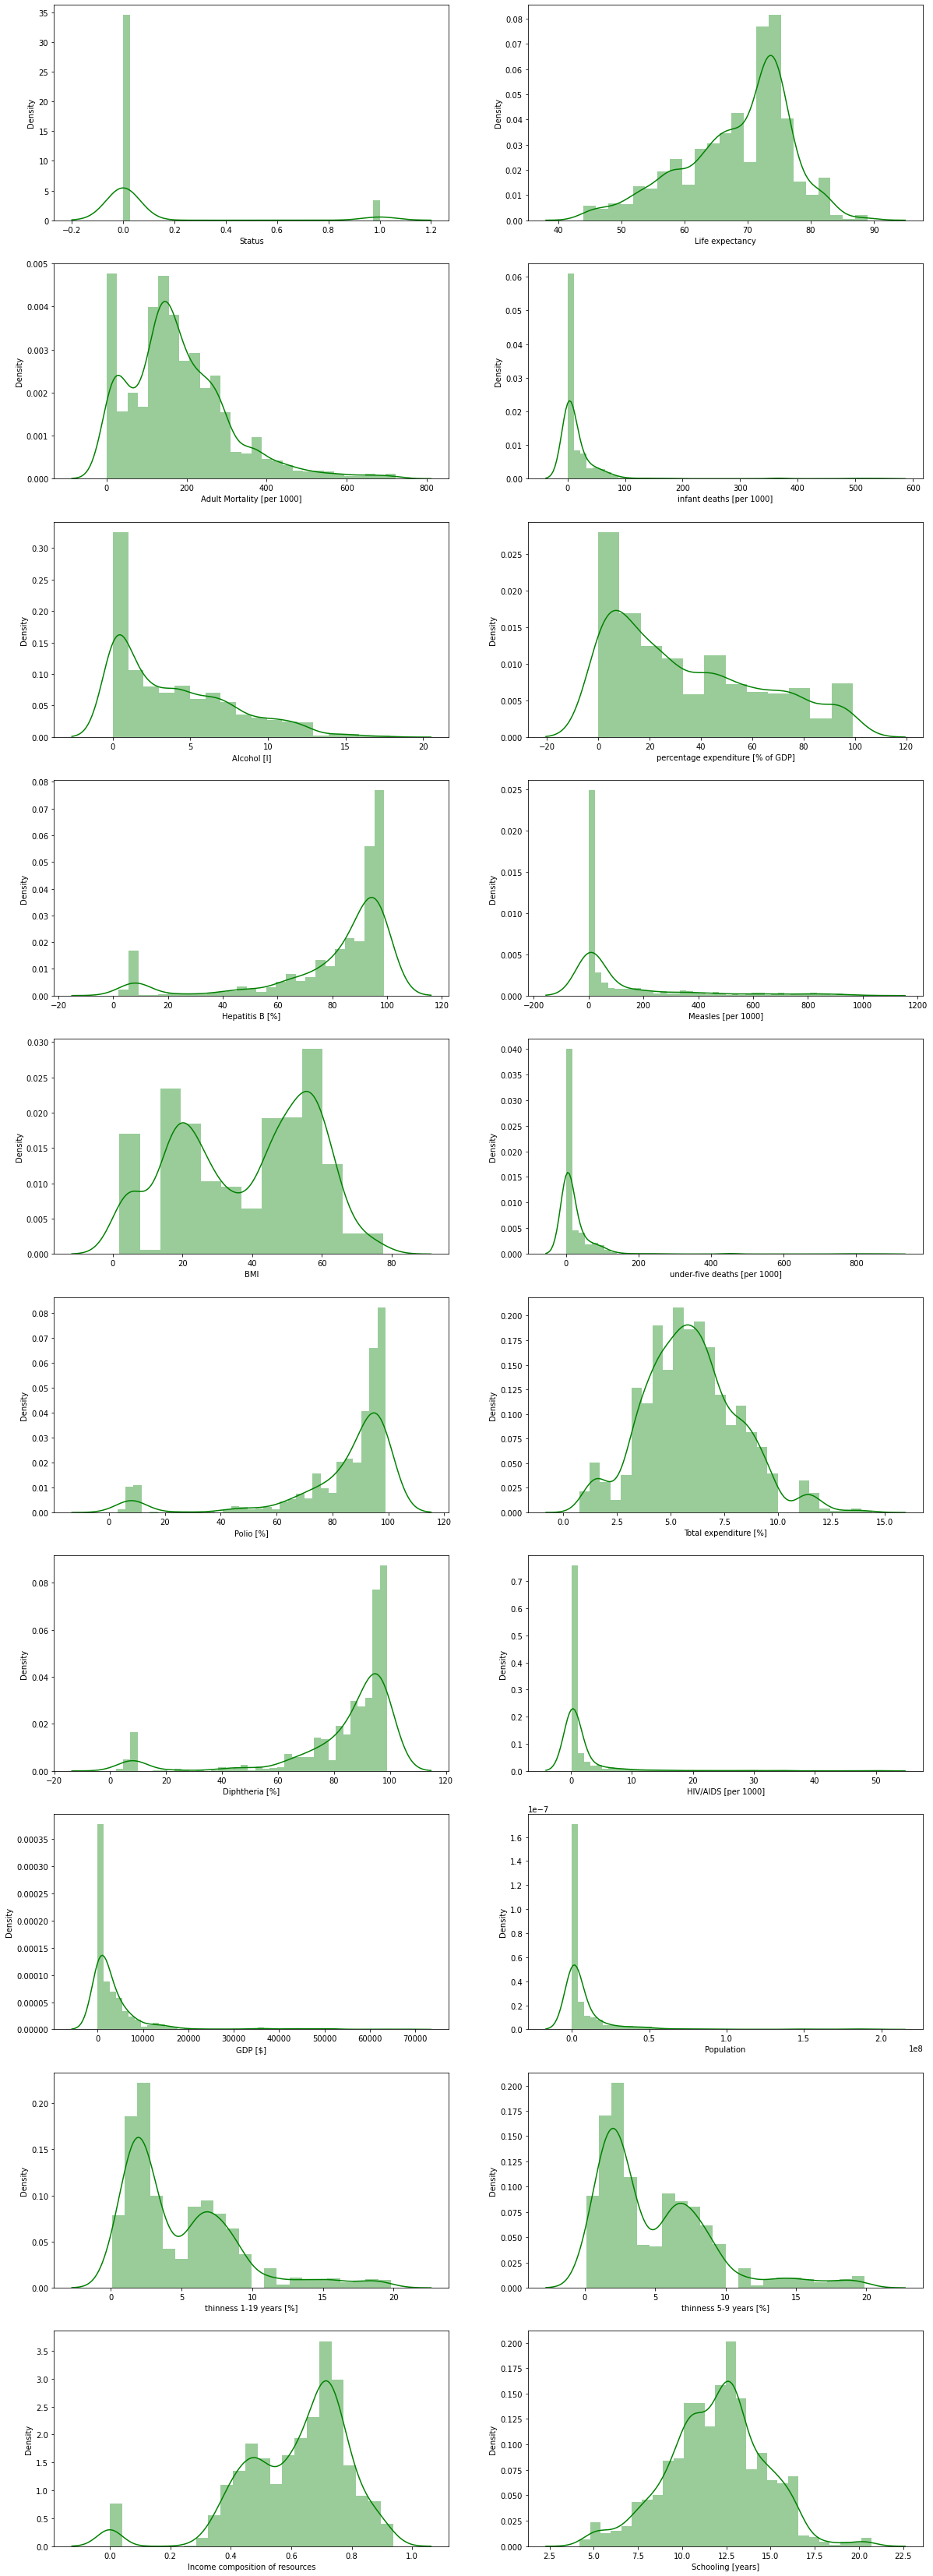

In [ ]:
attributes = data.columns
plt.figure(figsize=(20,60))
for i, attribute in enumerate(attributes):
    plt.subplot(10,2, i+1)
    sns.distplot(data.loc[:, attribute], color='g')
    plt.xlabel(attribute + " " + COLUMN_UNITS[attribute] if COLUMN_UNITS.get(attribute) is not None else attribute)

##### **Wnioski i obserwacje**

 - **Status**  
Istnieje duża przewaga państw rozwijających się nad rozwiniętymi. W dalszych etapach projektu należy zwrócić uwagę czy wyniki nie są uprzedzone względem państw rozwijających się.  
 - **Life expectancy**  
Dane nie są aż tak symetryczne (skośność wcale nie tak bliska 0) aczkolwiek są w miarę równomiernie rozłożone.
 - **Adult Mortality**  
Dane są raczej prawoskośne choć dosyć nietypowo biorąc pod uwagę piki w przedziałach 0-20 i 120-180 - mimo wszystko warto rozważyć transformację na rozkład bliższy normalnemu. Mało państw posiada śmiertelność powyżej połowy populacji.
 - **Infant Deaths**  
Rozkład prawoskośny z ogromną przewagą państw z niską śmiertelnością noworodków.   
 - **Alcohol**  
Prawoskośny z dużą przewagą państw o niskiej konsumpcji alkoholu.
 - **percentage expenditure**  
Rozkład prawoskośny o dosyć gładkim zejściu do wartości maksymalnej.  
 - **Hepatitis B**  
Rozkład lewoskośny z dosyć nietypowym pikiem przy 5%. Prawdopodobnie oznacza on pewien obszar/grupę państw, która wyjątkowo słabo radzi sobie z zapaleniami wątroby.  
 - **Measles**  
Rozkład prawoskośny z ogromną przewagą państw z bliską zeru ilością przypadków odry.
 - **BMI**  
Dosyć nietypowo rozłożone dane z dwoma pikami w okolicach 20 i 60.
 - **under-five deaths**  
Rozkład prawoskośny o ogromnej przewadze państw dla których ilość zgonów dla mniej niż 5-latków jest bliska zeru.  
 - **Polio**  
Rozkład lewoskośny z pikiem dla pewnych obszarów z pokryciem polio rzędu 5%.   
 - **Total expenditure**  
Całkiem symetryczny rozkład.  
 - **Diphteria**  
Rozkład prawoskośny z pikiem dla pewnych obszarów z pokryciem błonicy rzędu 7%.  
 - **HIV/AIDS**  
Rozkład prawoskośny z ogromną przewagą państw z bliską zeru śmiertelnością na AIDS.  
 - **GDP**  
Rozkład prawoskośny z ogromną przewagą państw z małym PKB (0 - 2000 [$]).  
 - **Population**  
Rozkład prawoskośny z ogromną przewagą państw ze względnie małą populacją.  
 - **thinness 1-19 i 5-19**  
Obydwa wykresy są do siebie bardzo podobne. Są one również (raczej) prawoskośne. Warto rozważyć redukcję jednej z tych cech i transformację na rozkład bliższy normalnemu.
 - **Schooling**  
Dosyć symetryczny rozkład. 
 - **Income composition of resources**  
Rozkład _raczej_ symetryczny z jednym nietypowym pikiem przy 0.
  
Poniżej przedstawiono wizualizacje różnych transformat do rozkładów bliższych normalnym.

In [ ]:
def plot_transformed(data, columns, normalising_transformations, colour='g'):
  fig, axs = plt.subplots(nrows=len(normalising_transformations), ncols=len(columns), figsize=(20, 40))

  for y, x in product(range(len(normalising_transformations)), range(len(columns))):
    sns.distplot(data[columns[x]].apply(normalising_transformations[y]), color=colour, ax=axs[y, x])

  plt.show()

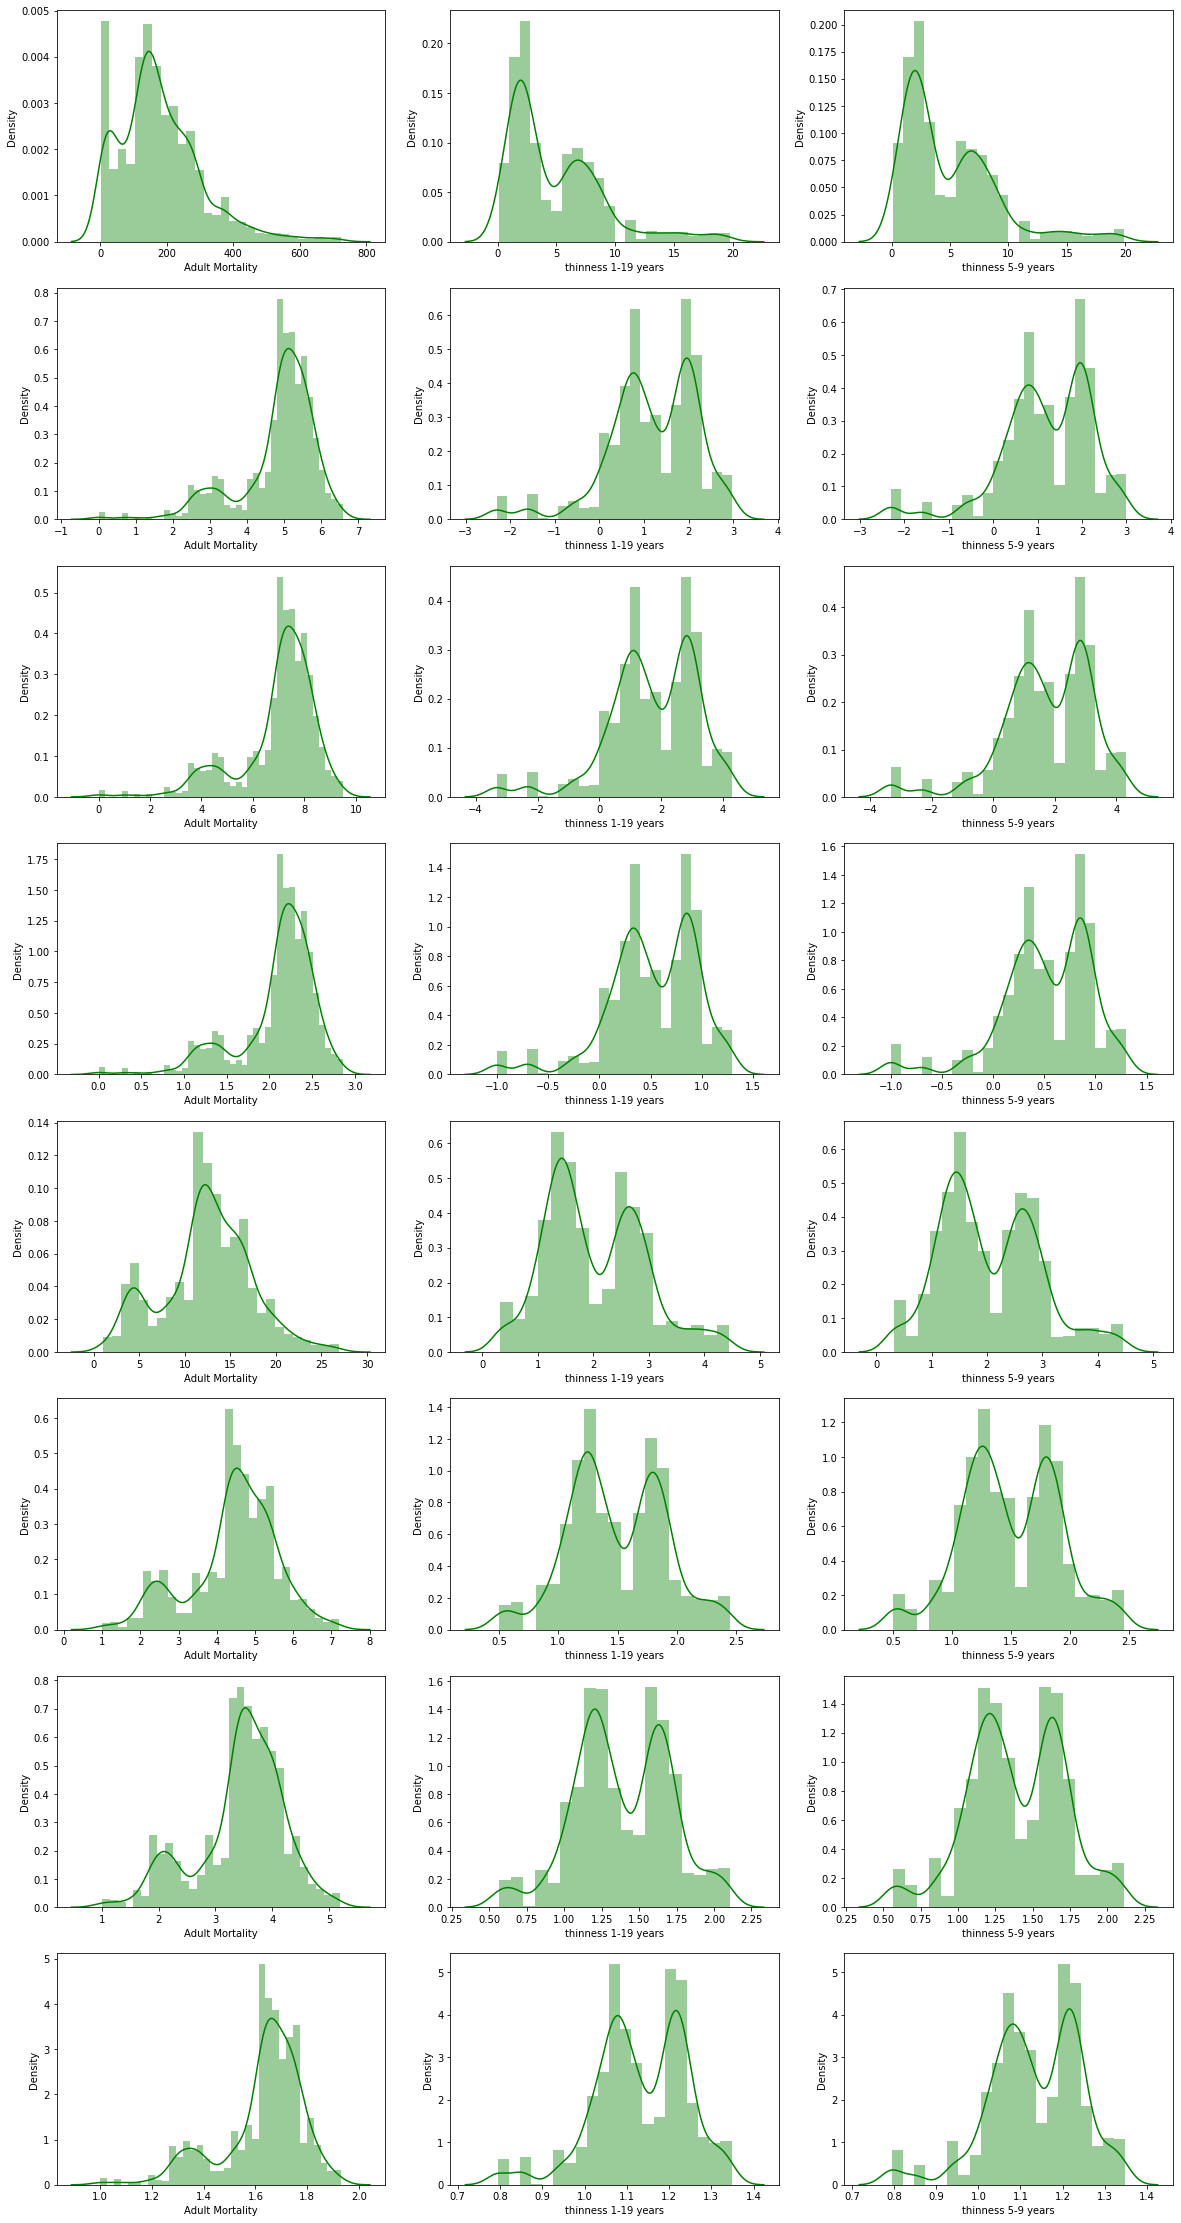

In [ ]:
DELTA = 0.000000000001
columns = ["Adult Mortality", "thinness 1-19 years", "thinness 5-9 years"]
normalising_transformations = [lambda x: x, lambda x: log(x + DELTA), lambda x: log2(x + DELTA), lambda x: log10(x + DELTA), lambda x: sqrt(x), lambda x: x**(0.3), lambda x: x**(0.25), lambda x: x**(0.1)]

plot_transformed(data, columns, normalising_transformations)

Istnieje dużo atrybutów, które posiadają mocno dominujące piki lub rozkłady strome z jednej strony - przy doborze nowych atrybutów warto będzie rozważyć transformacje tychże atrybutów, które "karałyby" dominujące wartości i ewentualnie pozwalały na bardziej symetryczny rozkład. 

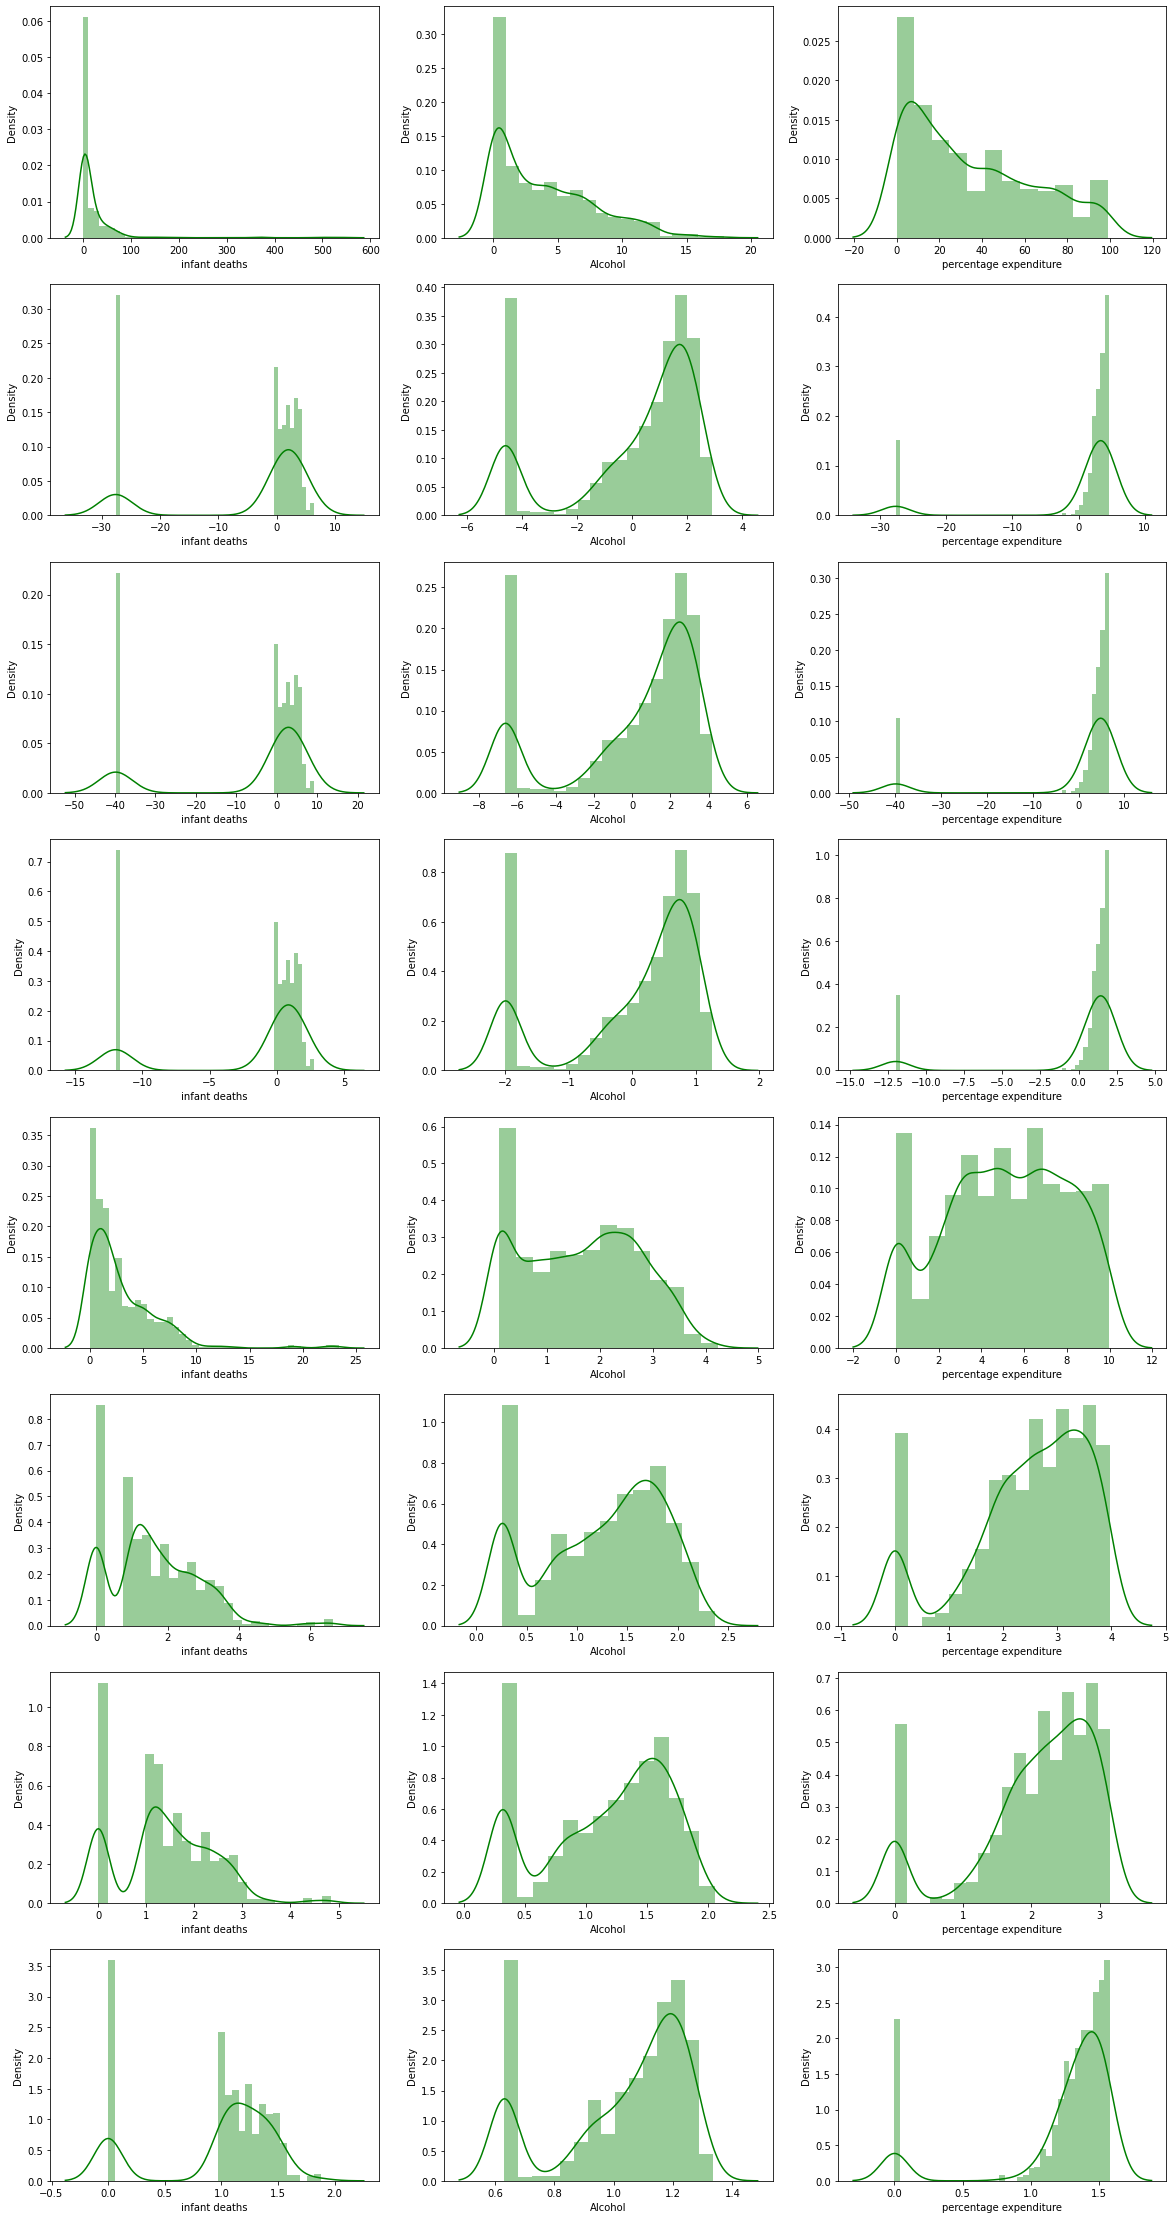

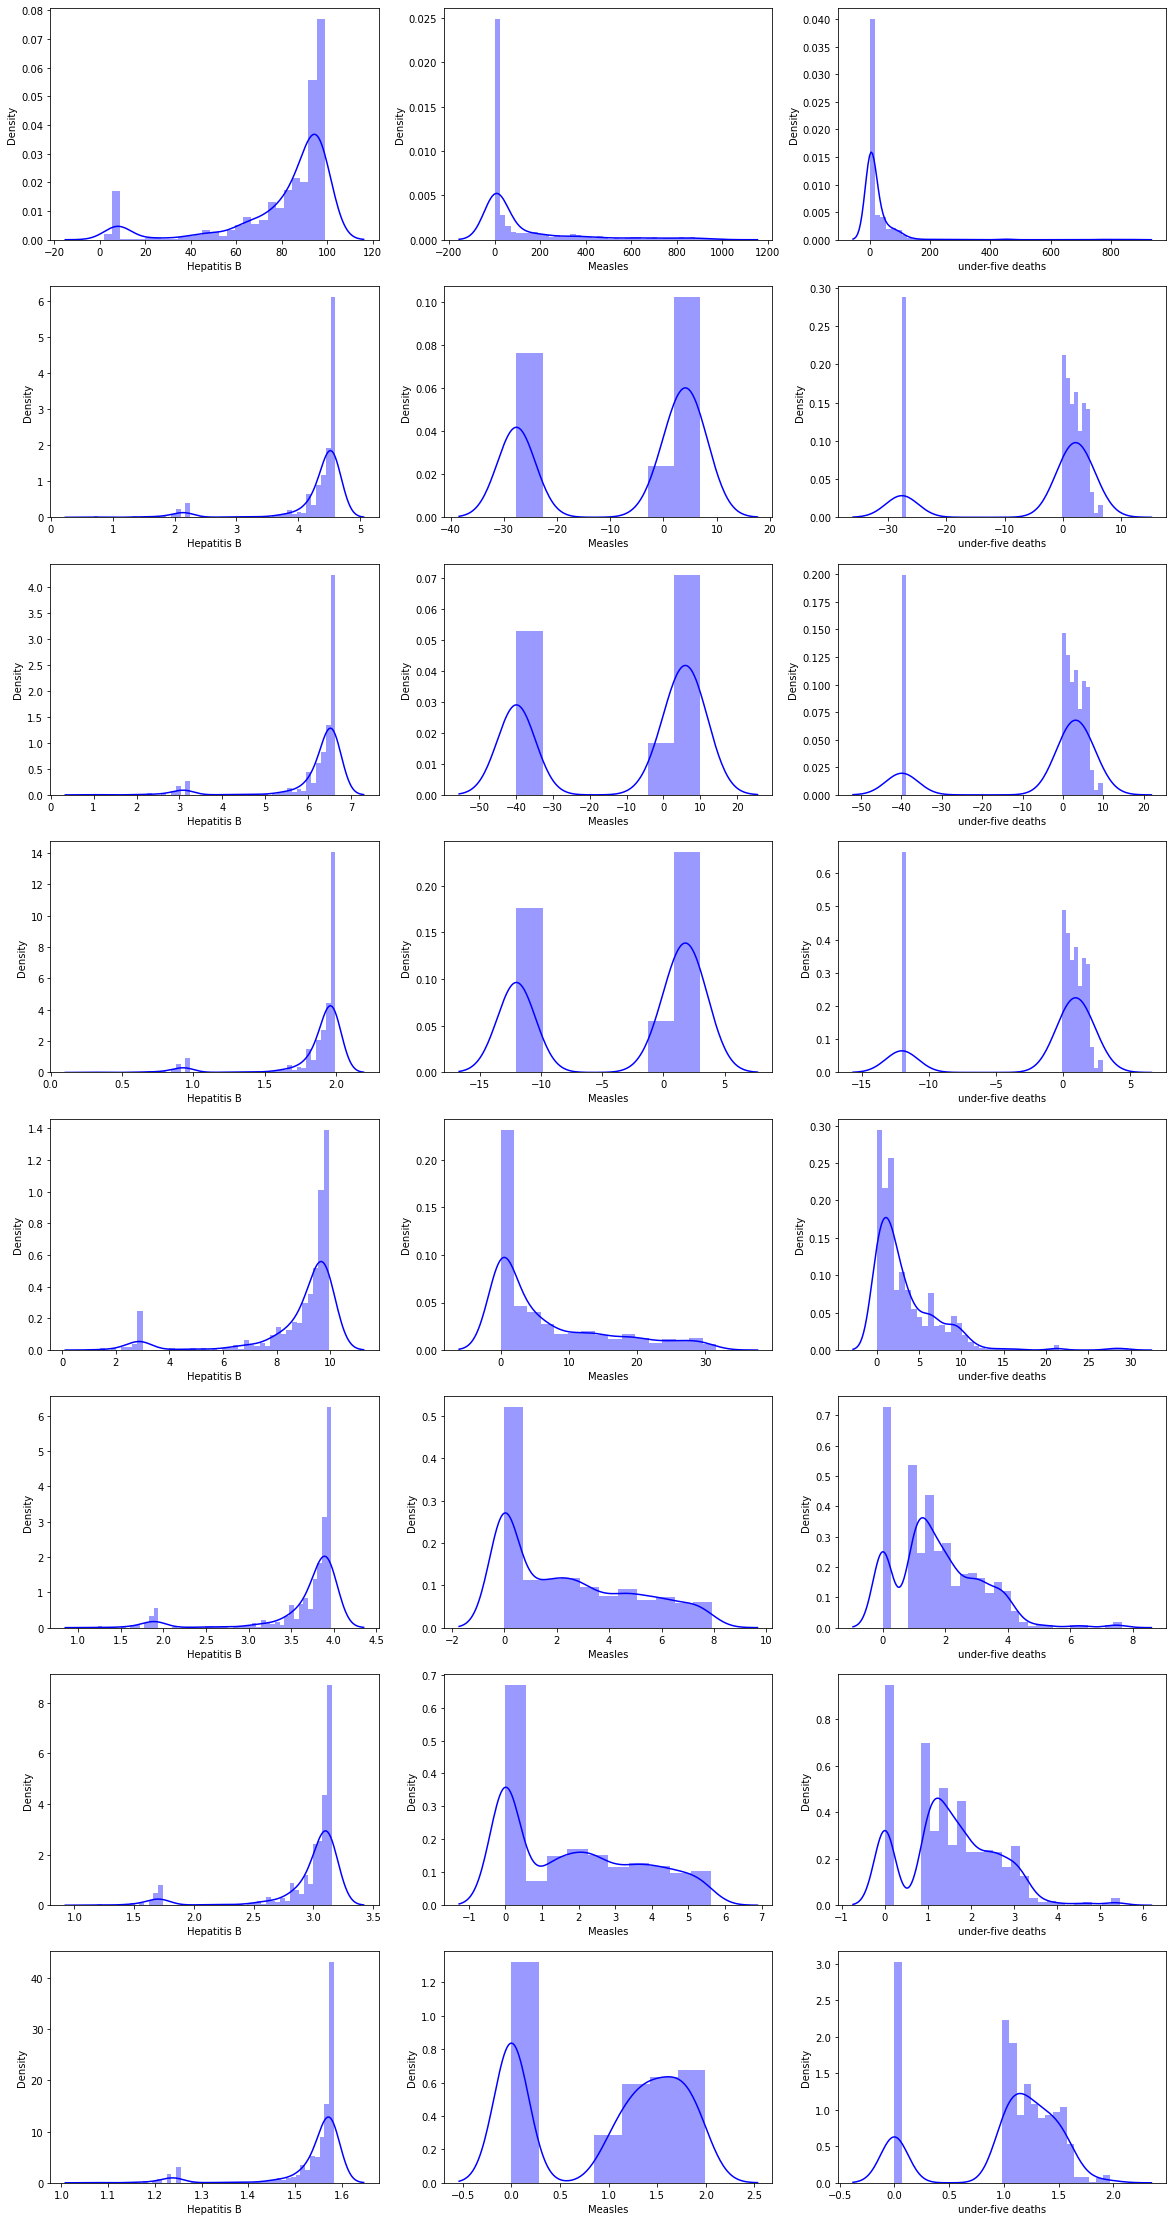

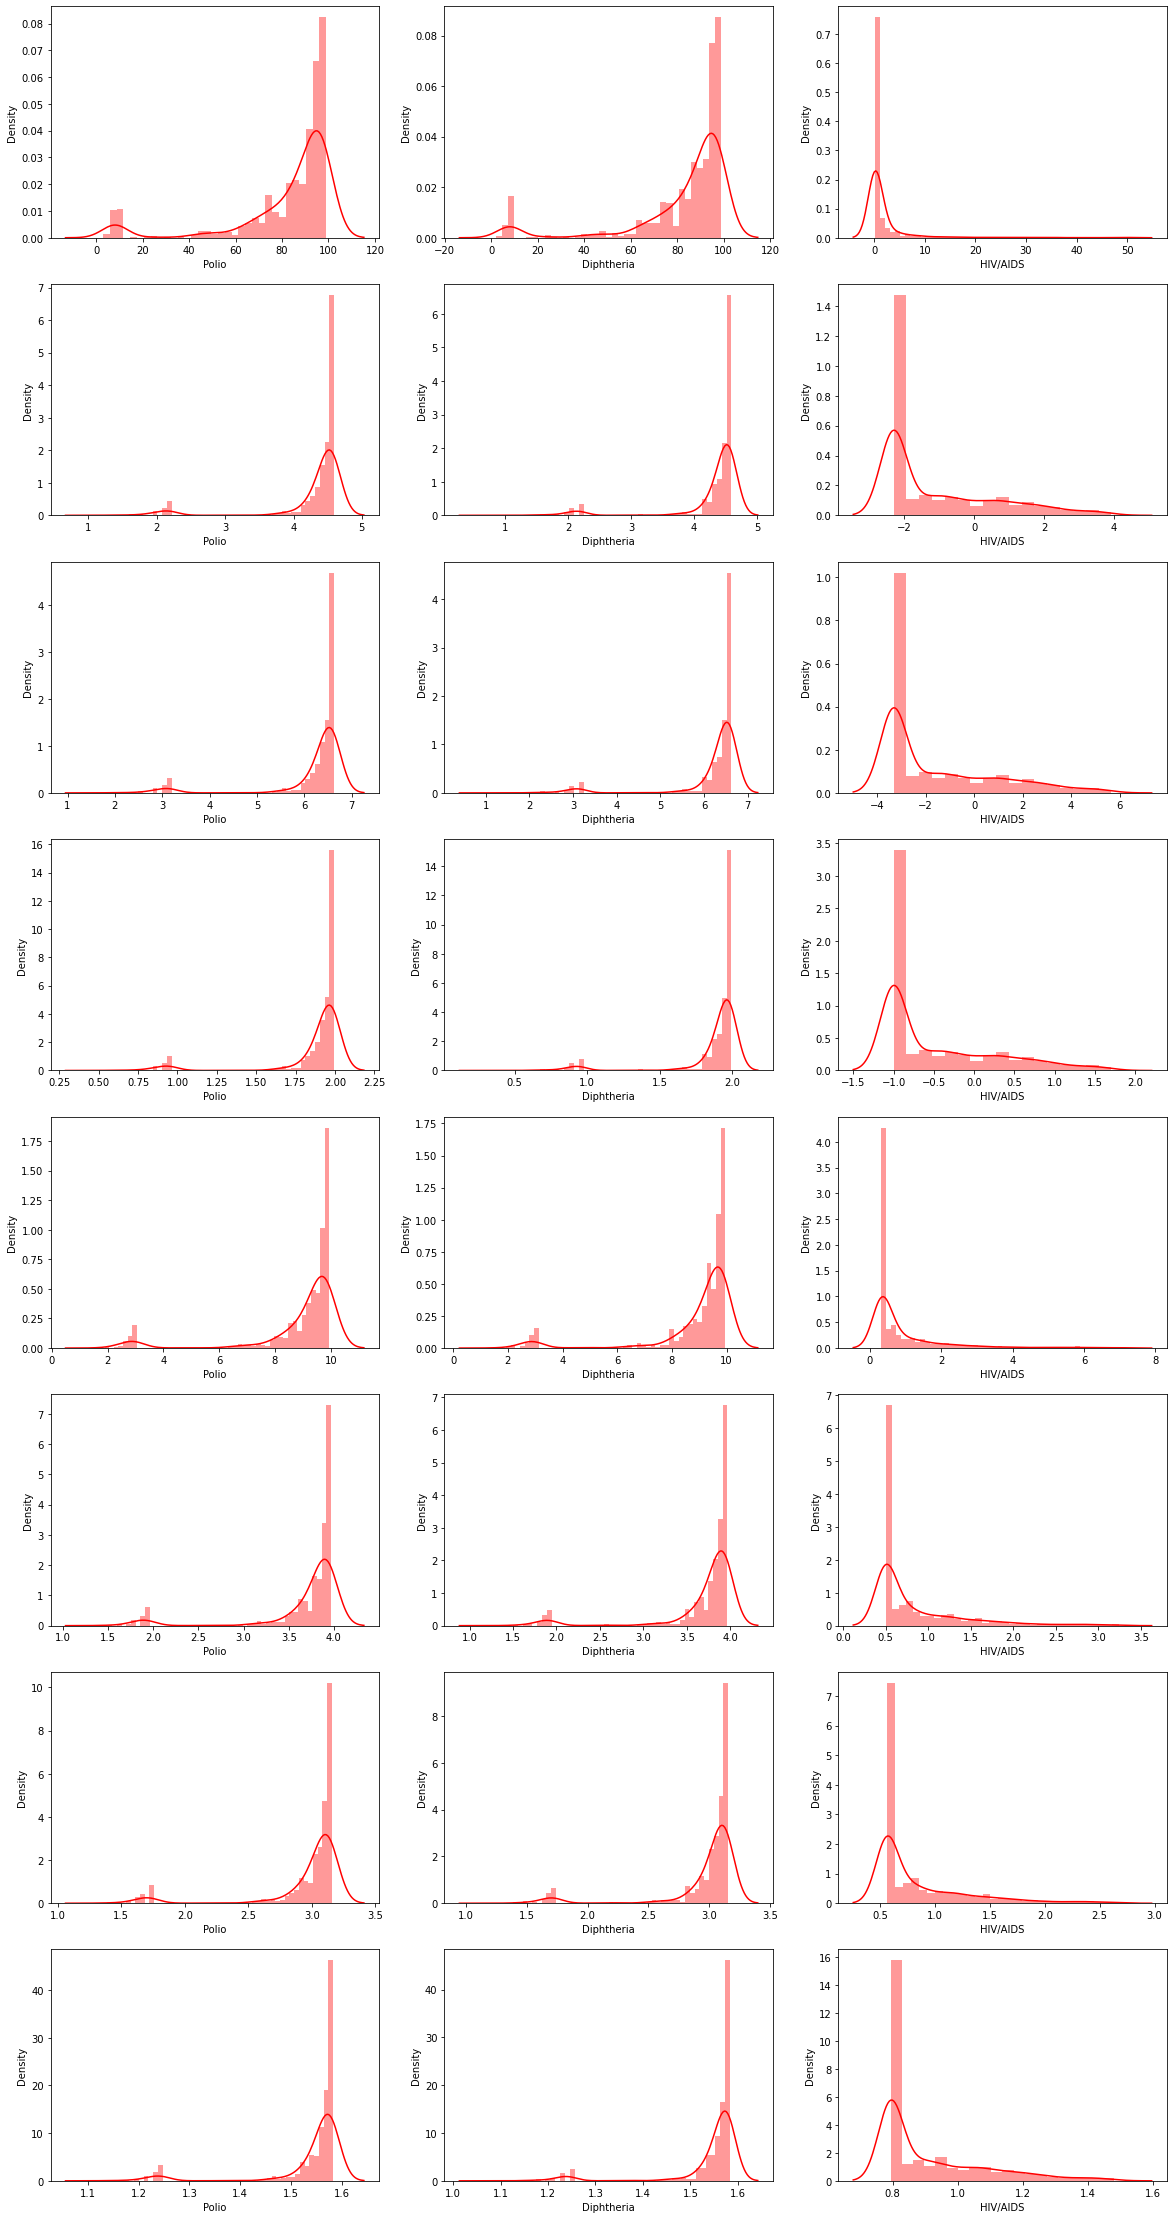

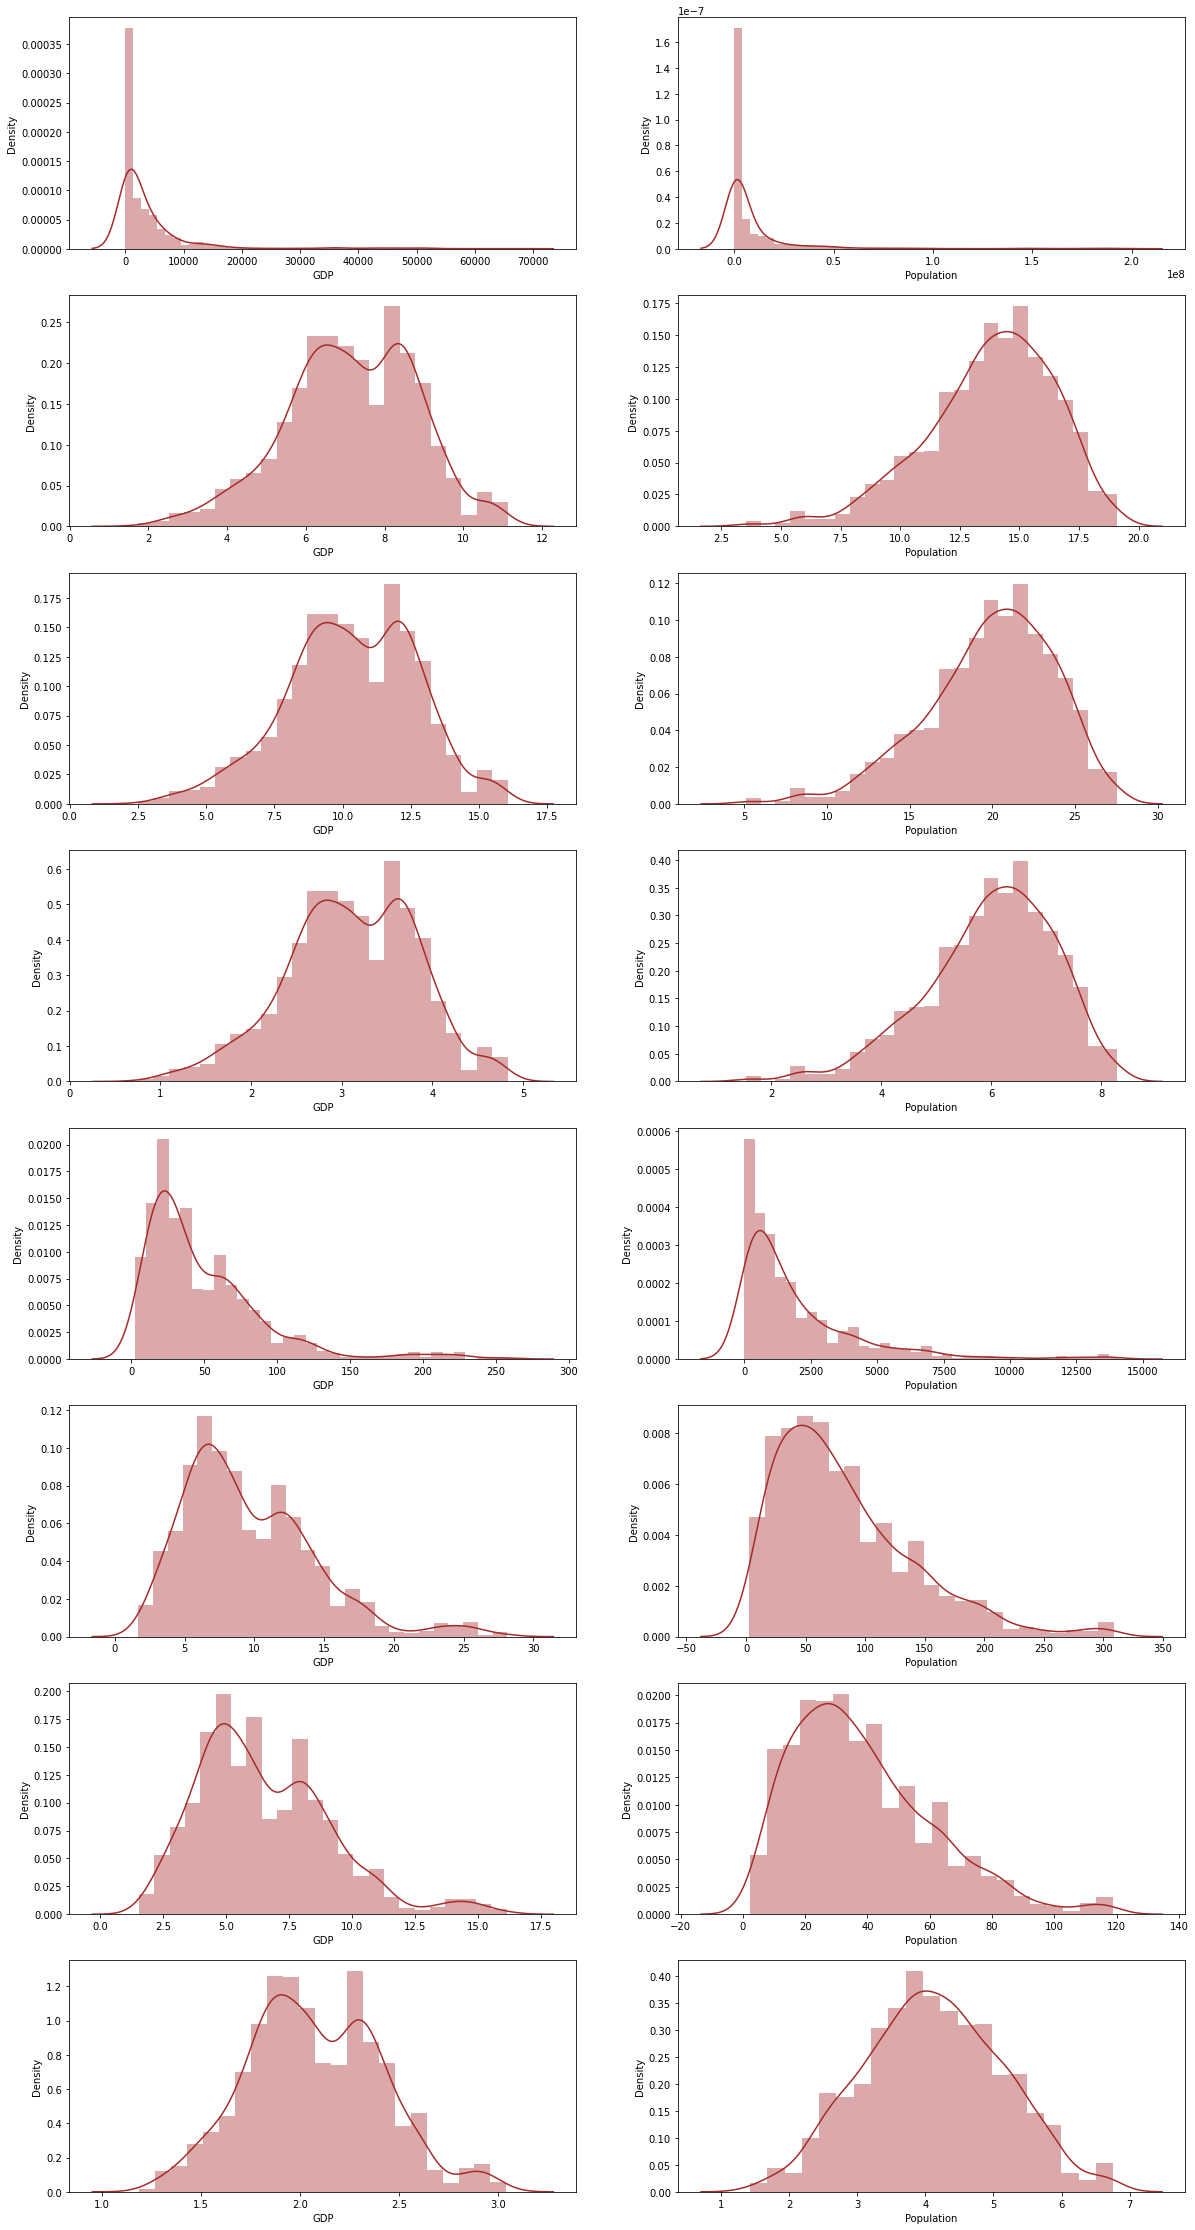

In [ ]:
columns = ["infant deaths", "Alcohol", "percentage expenditure", "Hepatitis B", "Measles", "under-five deaths", "Polio", "Diphtheria", "HIV/AIDS", "GDP", "Population"]
colours = ['g', 'b', 'r', 'brown']
chunk_size = 3
i = 0
while i < len(columns):
  end_index = min(i + chunk_size, len(columns))
  plot_transformed(data, columns[i : end_index], normalising_transformations, colours[i // chunk_size])
  i += chunk_size

Wiele z powyższych wykresów dowodzi zasadności takiego podejścia.

### **Badanie zakresów zmienności atrybutów**


---



Text(0.5, 1.0, 'Wykresy pudełkowe dla atrybutów')

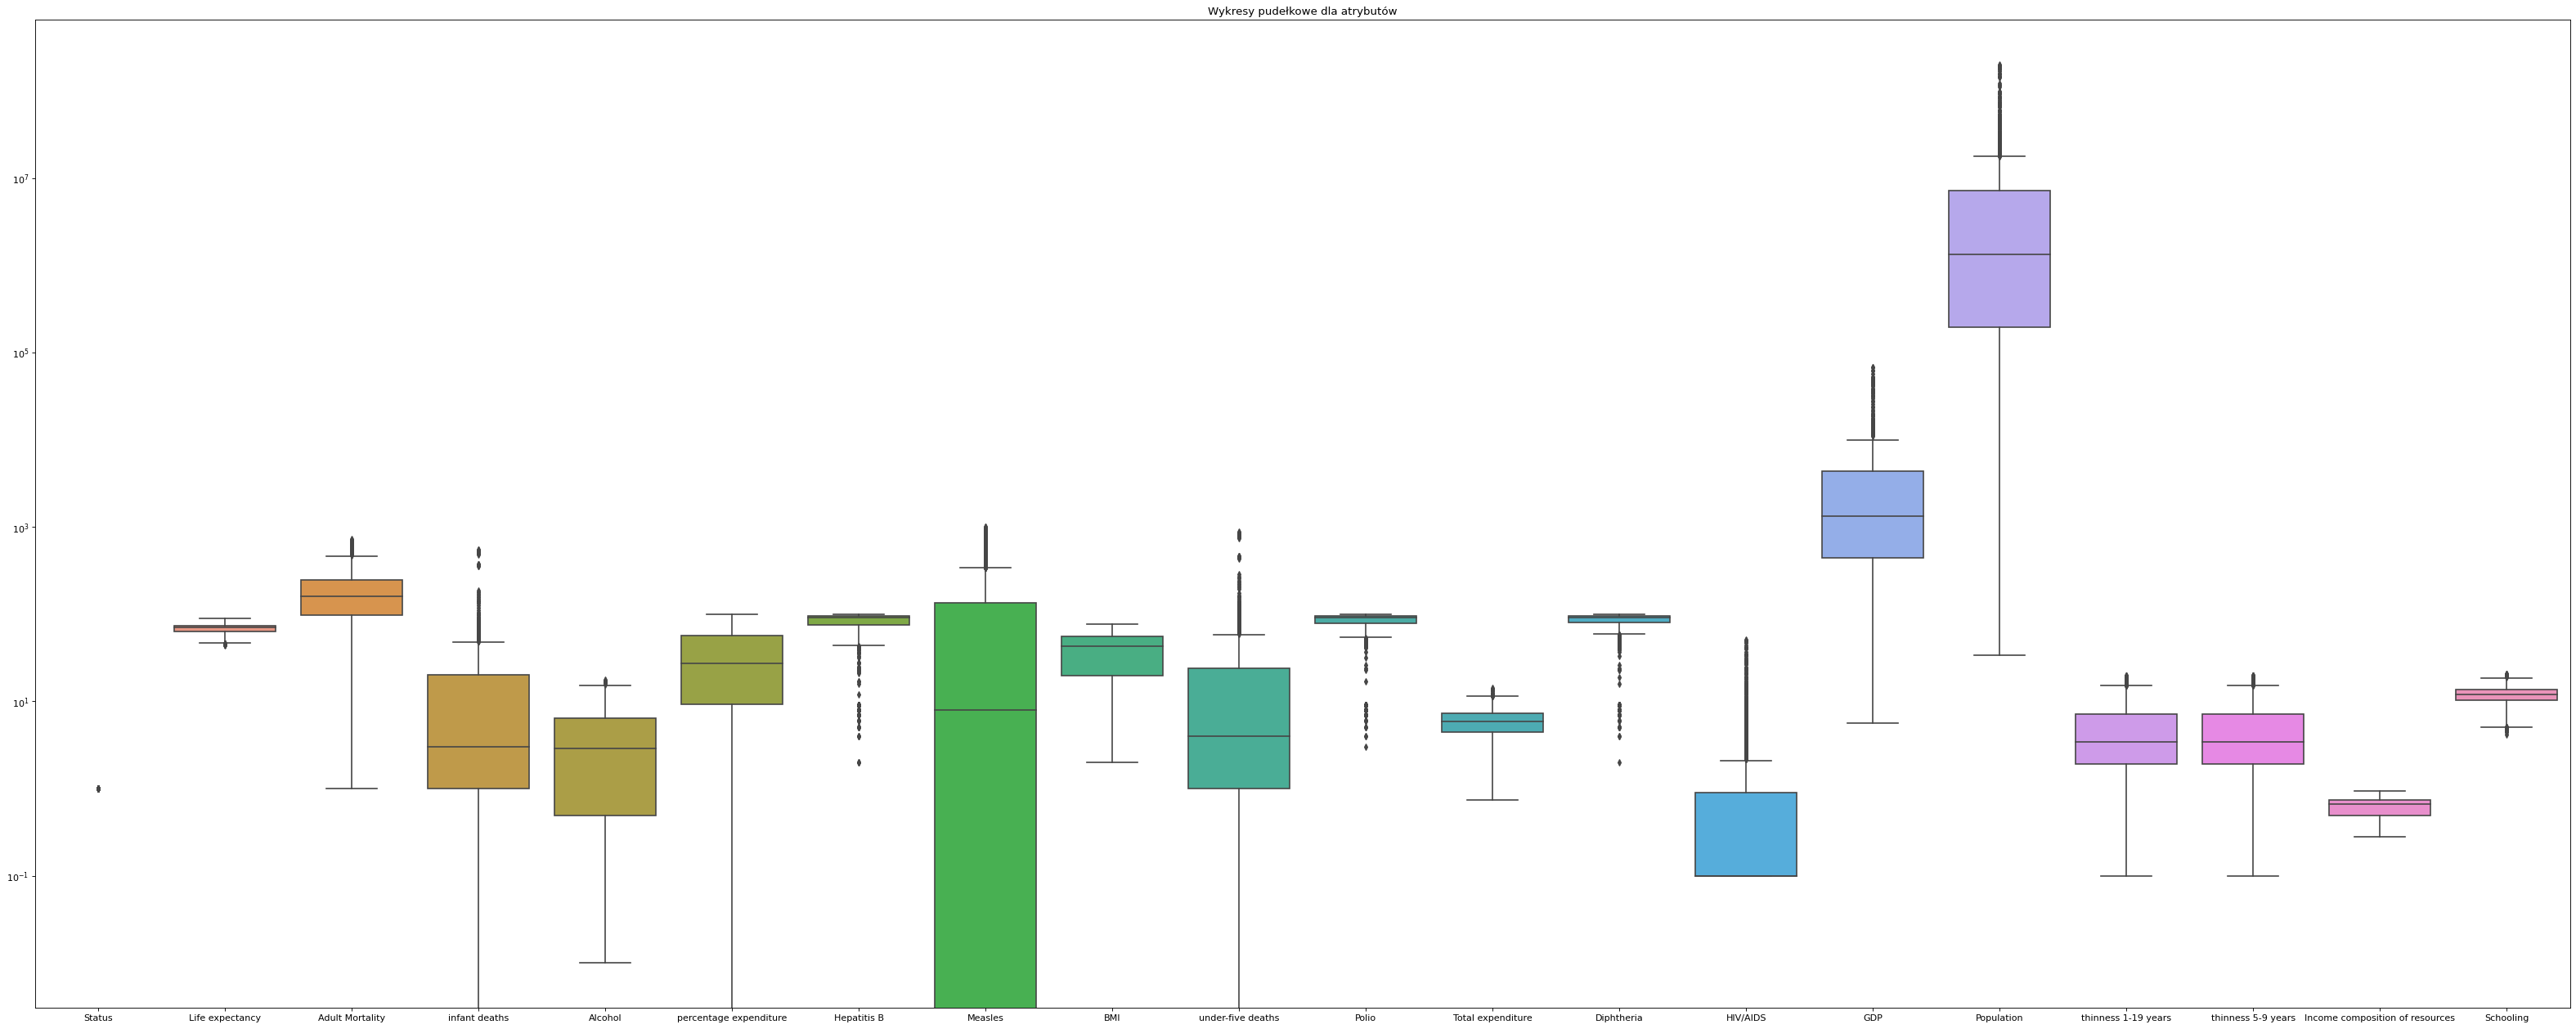

In [ ]:
attributes = data.columns
plt.figure(figsize=(50,20),dpi = 80)
bs = sns.boxplot(data=data[attributes])
bs.set_yscale('log')
plt.title("Wykresy pudełkowe dla atrybutów")

##### **Wnioski i obserwacje**

*   **Adult Mortality**  
Obszary pierwszego i trzeciego kwartyla są zbliżone i ich wartości nie odbiegają znacznie od mediany. Wartość minmalna znacznie odbiega od mediany. Inaczej jest w przypadku wartości maksymalnej, nie jest ona aż tak odległa. Widoczne są jednak wartości odstające powyżej niej. Rozkład jest asymetryczny. 
*   **Alcohol**	
Więcej obiektów należy do Q3 niż do Q1. Wartość min odbiega od mediany znacząco bardziej niż wartość maksymalna. Widać na tym prawoskośność rozkładu.
Występują nieliczne wartości odstające powyżej max.
*   **Hepatitis B**	
Na wykresie od razu łatwo można zauważyć znaczącą ilość wartości odstających. Wartość max jest bardzo zbliżona do mediany i praktycznie styka się z górną krawędzią pudełka (końcem trzeciego kwartyla). Oznacza to, że atrybut ten przyjmuje zbliżone do siebie, duże wartości. Oznacza to, że szczepienia przeciwko wirusowemu zapaleniu wątroby typu B są powszechne i można wnioskować, że w wielu krajach obowiązkowe.
*   **Measles**	 
Zachorowania na odrę mają bardzo szeroki zakres zmienności, od 0 aż do 999 możliwych przypadków zachorowań na 1000 osób. Jest dysproporcja między pierwszym a trzecim kwartylem — trzeci jest większy. Co więcej, wartość max jest bardziej zbliżona do górnej wartości Q3 niż min do dolnej wartości Q1. Mamy więc do czynienia z asymetrią.
*   **BMI**	
W BMI nie ma wartości odstających. Max wartość jest zbliżona do mediany, a minimalna bardzo od niej odległa. Jest dysproporcja między obszarem Q1 i Q2, ale nie bardzo duża. Więcej badanych miało BMI poniżej mediany. Wartości BMI nie miały podanego zakresu zmienności w opisie kolumn ale BMI >40 oznacza już otyłość znacznego stopnia, więc wartości powyżej tego wydają się błędne. 
*   **under-five deaths**  
Atrybut charakteryzuje się wysokim zakresem zmienności. Wartość min styka się z osią rzędnych. Występuje dużo wartości odstających powyżej max. Obszar kwartyla trzeciego jest większy niż drugiego.
*   **Polio**	
Na wykresie widać dużo wartości odstających, ale obszar między wartością min i max jest bardzo wąski. Mediana ma wysoką wartość i praktycznie pokrywa się z wartością maksymalną. W tym przypadku większość niemowląt jest także ogólnie zaszczepiona na Polio. 
*   **Total expenditure**  
Na wykresie można zaobserwować, że mniej więcej taki sam jest obszar Q1 I Q3. Wartości więc układają się w przybliżeniu zgodnie z rozkładem normalnym. Większość państw tyle samo przeznacza na dbanie o zdrowie swoich obywateli. Warto zauważyć, że max wartość to nadal zaledwie ok.14%.
*   **Diphtheria**	
Na wykresie widać dużo wartości odstających, ale przyciąga uwagę fakt, że w przypadku szczepień na tę chorobę jak i innych wypisanych wyżej wartość mediany jest bliska wartości maksymalnej co oznacza, że poziom szczepień na świecie jest wbrew intuicyjnym przewidywaniom wysoki.
*   **HIV/AIDS**	
Wykres wygląda nietypowo, ciężko powiedzieć, w którym miejscu jest mediana dlatego ustaliliśmy ją dodatkowo przy pomocy funkcji  median z pakietu statistics. Wynosi ona 0.1 i pokrywa się z wartością min. Oznacza to, że umieralność na HIV/AIDS w badanej grupie wiekowej jest bardzo mała. Na wykresie widać dużo wartości odstających powyżej max.
*   **GDP**	
GDP ma wartość min dużo poniżej mediany. Zakres zmienności tego atrybutu jest wyjątkowo szeroki co jest zrozumiałe, ponieważ (co będzie szerzej omawiane w dalszej części) jest kilka krajów, które generują większość GDP na świecie.
*   **Population**	
W przypadku wielkości populacji również mamy bardzo szeroki zakres zmienności. Powyżej wielkości max występują też wartości odstające. Q1 i Q3 są podobnej wielkości. Wartość min jest znacznie mniejsza niż mediana. 
*   **thinness 1-19 years i thinness 5-9 years**	
Wykresy wyglądają prawie identycznie. Wartość min jest znacząco niższa niż mediana, wykresy charakteryzują się wysokim zakresem zmienności, a kwartyl trzeci ma większą powierzchnię niż pierwszy. Występują nieliczne wartości odstające.
*   **Income composition of resources**	
W opisie kolumny było zaznaczone, że wartości są z zakresy 0-1. Wartości min i max są odległe od mediany w dość podobnym stopniu (chociaż wartość max jest jej bliżej) ale kwartyl trzeci jest o wiele szerszy niż pierwszy. Mało jest więc wartości powyżej mediany co oznacza, że mało jest państw ponadprzeciętnie rozwiniętych.
*   **Schooling**  
Wykres jest całkiem symetryczny — Q1 i Q3 zajmują podobny obszar. Zakres zmienności tego atrybutu jest dość mały. Występują nieliczne wartości odstające poniżej min.








### **Badanie korelacji**


---



Text(0.5, 1.0, 'Macierz korelacji')

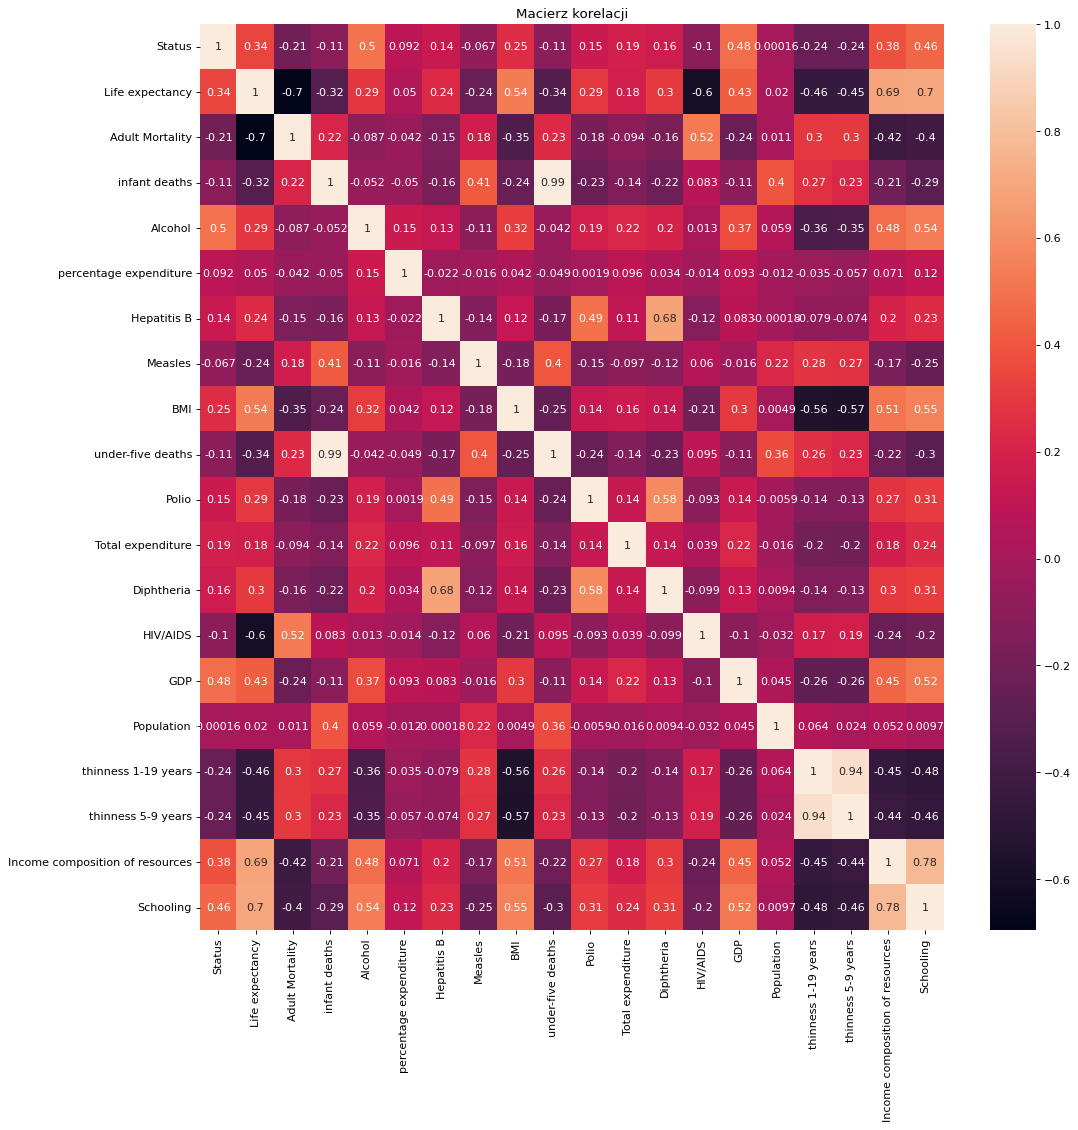

In [ ]:
plt.figure(figsize=(15,15),dpi = 80)
sns.heatmap(data.corr(),annot = data.corr())
plt.title("Macierz korelacji")

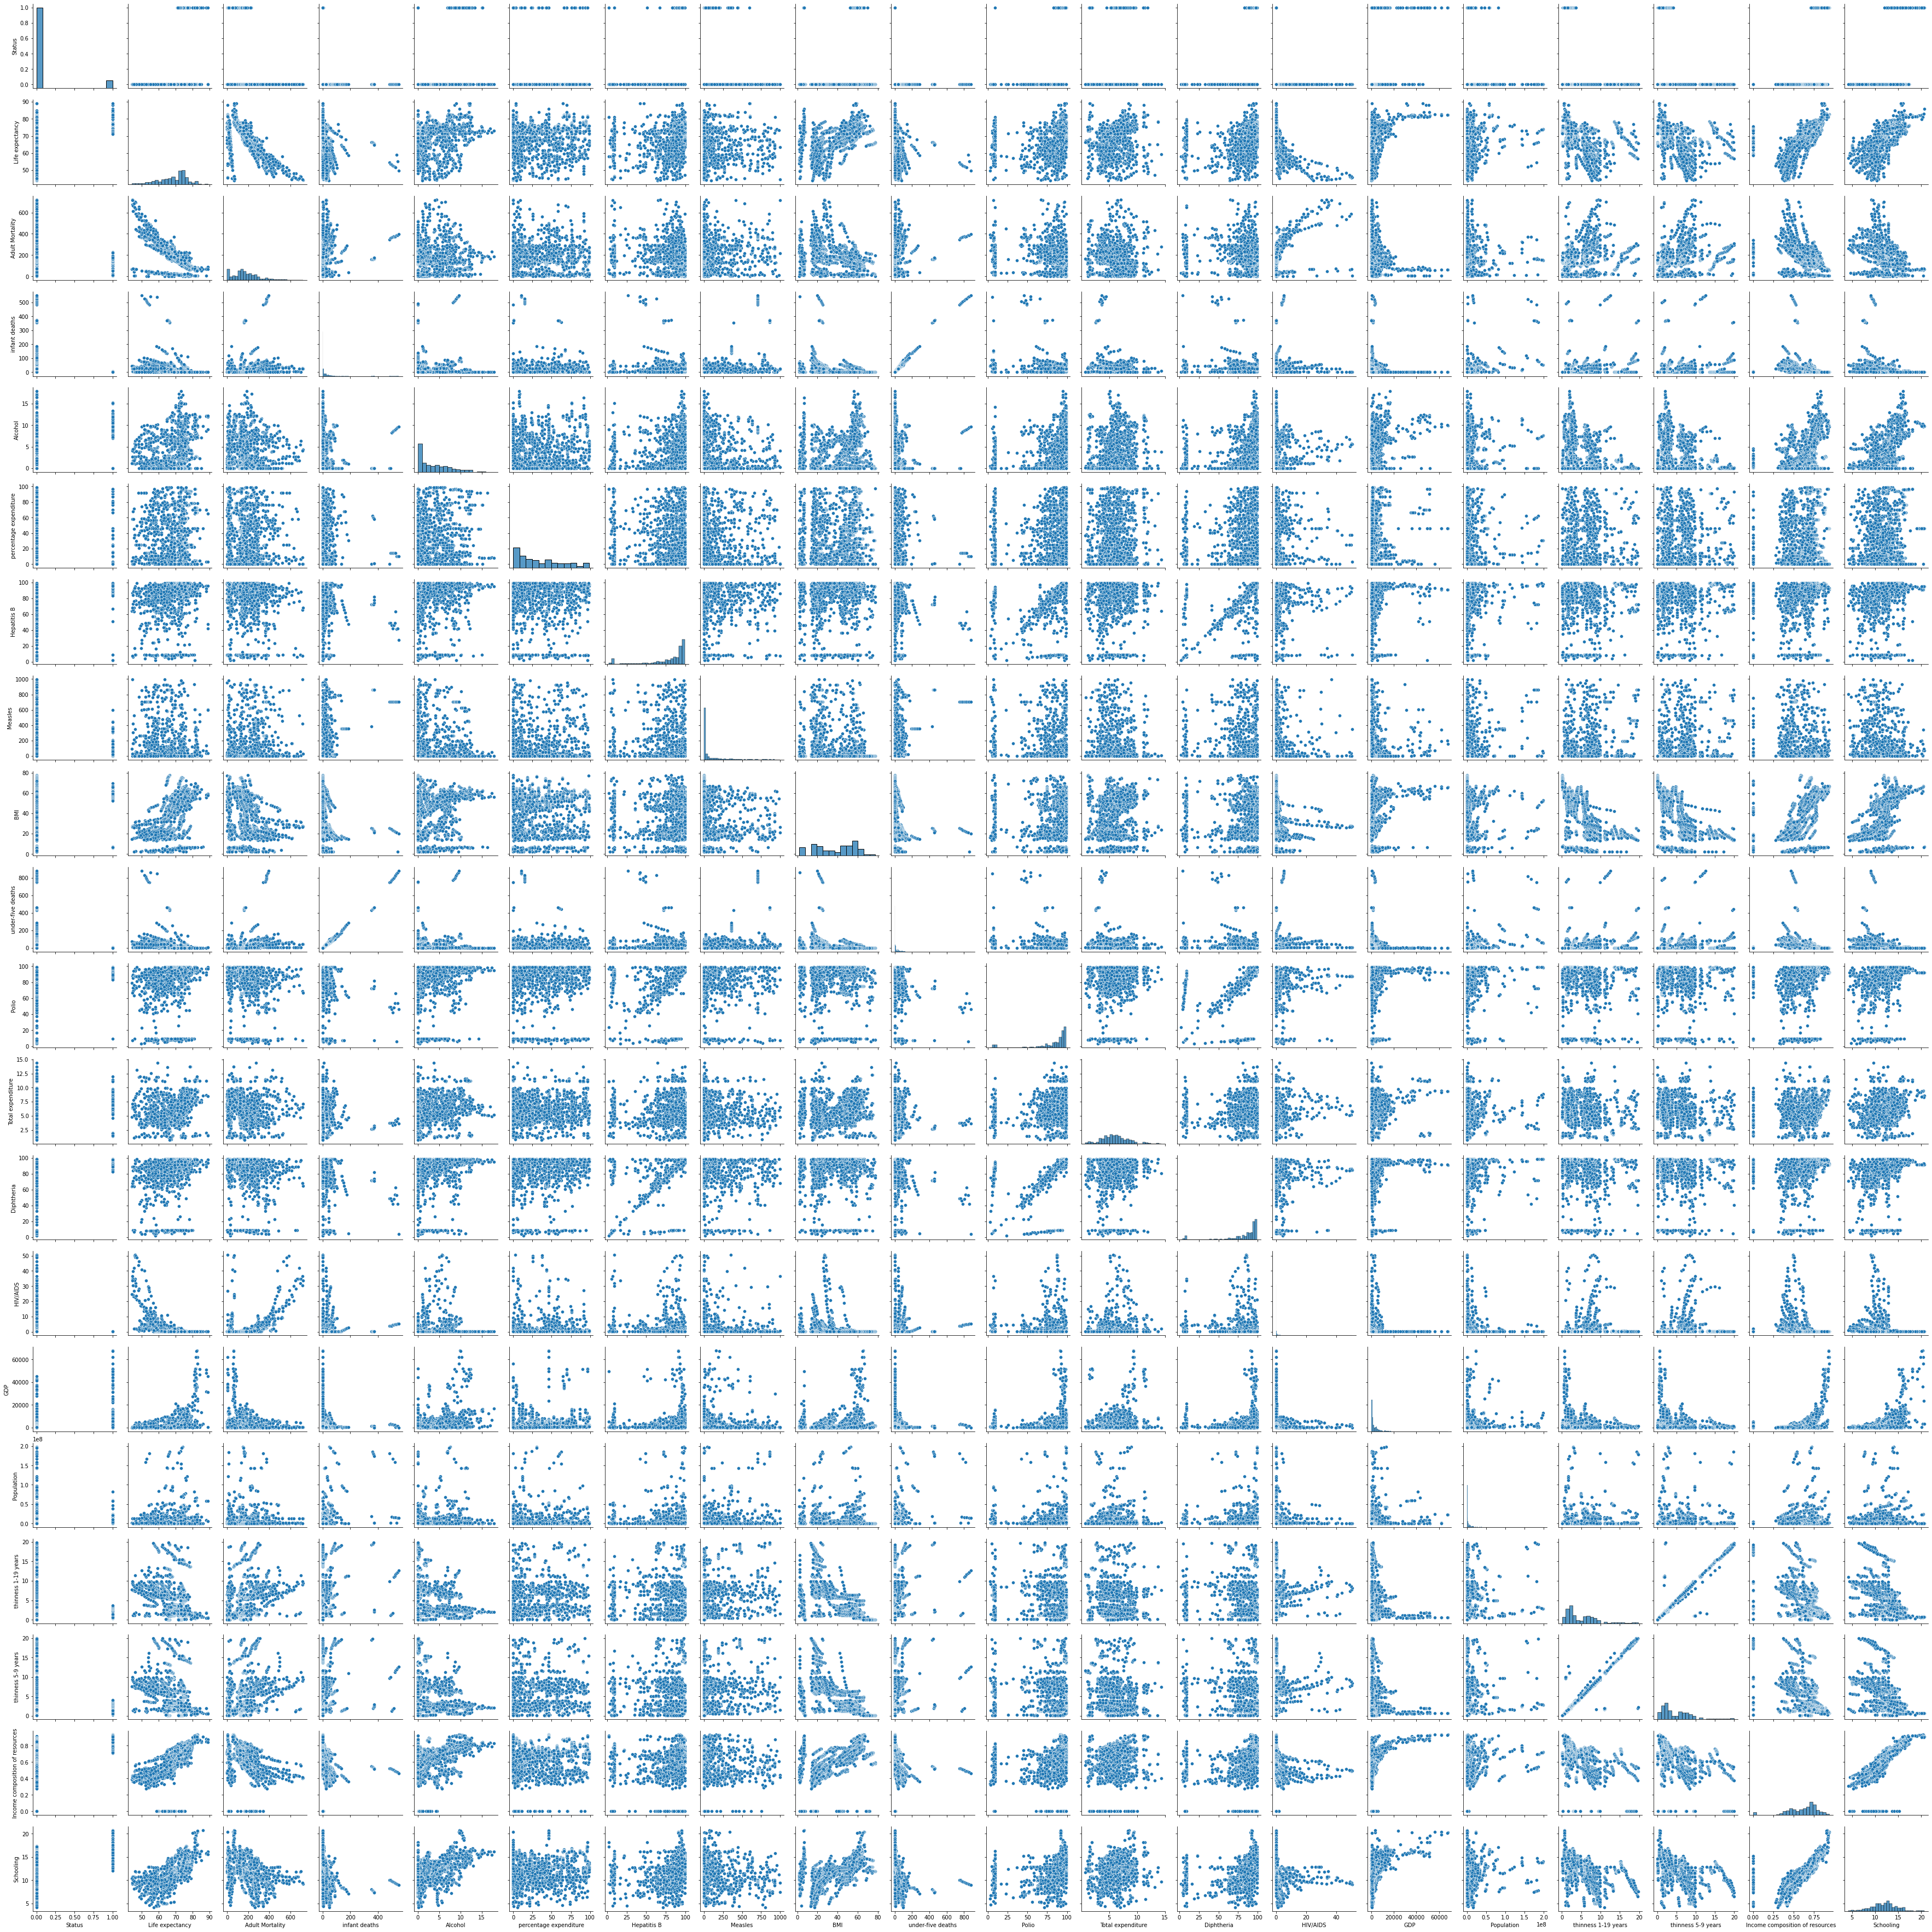

In [ ]:
sns.pairplot(data, kind="scatter")
plt.show()

##### **Wnioski i obserwacje**

*   Pomiędzy atrybutami Polio, Hepatitis B, Diphtheria parami występują parami dodanie korelacje. Największa między Diphtheria i Hepatitis B wynosi 0.68. Prawdopodobną przyczyną jest to, że w krajach, w których upowszechniło się szczepienie niemowląt są one szczepione na  popularne chorób.
*   Występuje ujemna korelacja między thinness i BMI co jest zrozumiałe, ponieważ BMI właśnie określa czy masa ciała jest prawidłowa. Korelacja wynosi -0.56 i -0.57.
*   Istnieje dodatnia korelacja między poziomem szkolnictwa, a GDB (wynosi 0.52). Pokazuje to, że im bardziej państwo inwestuje w edukację dzieci, tym lepszy jest poziom rozwoju ekonomicznego.
*   Pomiędzy Income composition of resources i Schooling występuje silna, dodatnia korelacja równa 0.78. Na obliczenie wskaźnika HDI składa się m.in. właśnie czas kształcenia dzieci w szkole. HDI jest też skorelowane na przeciętnym poziomie z GDP (0.45) - oczekiwaliśmy wyższej korealcji, ponieważ na ten czynik składa się także dochód nardodowy kraju per capita. Atrybut ten jest też skorelowany z BMI (0.51) i spożyciem alkoholu (0.48). 
*   Jak zostało wspomniane we wcześniejszym podpunkcie, atrybut Income composition of resources jest zależny od pewnych wskaźników. Jednym z nich jest właśnie średnia długość życia (stąd ich duża korelacja - 0.69). Mając na uwadze, że celem dalszych prac będzie przewidywanie tego atrybutu sensownym będzie nie rozważanie tego atrybutu. 
*   Bardzo wysoką korelacją charakterują się thinness 1-19 years i thinness 5-9 years. Na wykresach widać, że punkty układają się prawie idealnie w funkcję liniową. Można więc zostawić tylko jeden z tych atrybutów.
*   Wysoką korelacją charakteryzują się również atrybuty infant deaths i under-five deaths. Wykres punktowy zdaje się to potwierdzać, więc możnaby odrzucić jeden z tych atrybutów




### **Teza badawcza**

---

Rozważając uzyskane wnioski postawić by można następującą tezę

#### **"Wpływ wskaźników edukacji, BMI, HIV i AIDS jest przeważający w modelach przewidywania średniej długości wieku"**

### **Dobór cech**


Zgodnie z analizami przeprowadzonymi powyżej możemy odrzucić atrybuty Income composition of resources, thinness 1-19 years oraz infant deaths.

In [ ]:
data_cleaned = data.copy()
data_cleaned.drop(['thinness 1-19 years', 'Income composition of resources', 'infant deaths'], axis=1, inplace=True)

Zawczasu możemy ze zbioru danych wydobyć badaną wartość.

In [ ]:
life_expectancy = data_cleaned['Life expectancy']
data_cleaned.drop('Life expectancy', axis=1, inplace=True)

#### **Propozycje nowych cech na podstawie naszej wiedzy**


Dodaliśmy nową cechę under_five_deaths_square, która powstała poprzez podniesienie 'under-five deaths' do kwadratu, ponieważ duża śmiertelność wśród dzieci poniżej 5 roku życia będzie miała znaczący wpływ na obniżenie średniej długości życia.

In [ ]:
data_cleaned['under_five_deaths_square'] = data_cleaned['under-five deaths']*data_cleaned['under-five deaths']

Kolejną propozycją cechy jest cecha HIV_AIDS_square, która powstała poprzez podniesienie do kwadratu 'HIV/AIDS', ponieważ wysoka śmiertelność na HIV i AIDS również przyczyni się do obniżenia średniej długości życia.



In [ ]:
data_cleaned['HIV_AIDS_square'] = data_cleaned['HIV/AIDS']*data_cleaned['HIV/AIDS']

Cechą, która z kolei powinna przyczynić się do podwyższenia średniej długości życia jest percentage_expenditure_schooling. Cecha ta powstała poprzez pomnożenie atrybutów 'Schooling' i 'percentage expenditure'. Zwiększone wydatki na służbę zdrowia, a także wysoki poziom szkolnictwa świadczą o tym, że obywatele mają dużą świadomość tego jak dbać o zdrowie, oraz że mają wsparcie finansowe od państwa, aby poprawiać jego stan.

In [ ]:
data_cleaned['percentage_expenditure_schooling'] = data_cleaned['percentage expenditure']*data_cleaned['Schooling']

Wprowadzimy również cechę będącą złożeniem wszystkich tych, które opisują śmiertelność na choroby na które istnieją szczepionki. Motywacją jest tu wprowadzenie ogólnej miary określającej istotność szczepień. Dane zostały znormalizowane ze względu na różne jednostki tych miar (%, per 1000, etc.).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data_cleaned["cases_of_preventable_diseases"] = MinMaxScaler().fit_transform(data_cleaned["Diphtheria"].values.reshape(-1, 1)) *\
                                                  MinMaxScaler().fit_transform(data_cleaned["Polio"].values.reshape(-1, 1)) *\
                                                  MinMaxScaler().fit_transform(data_cleaned["Measles"].values.reshape(-1, 1)) *\
                                                  MinMaxScaler().fit_transform(data_cleaned["Hepatitis B"].values.reshape(-1, 1))

#### **Propozycje nowych cech na podstawie analizy skrzywienia i koncentracji**

Ze względu na dużą liczbę cech asymetrycznych i/lub z odstającymi wartościami, rozpatrzymy je wszystkie przy doborze optymalnych funkcji transformujących.

In [ ]:
DELTA = 1.000000000001
normalising_transformations = {
    "log_e": lambda x: log(x + DELTA), 
    "log_2": lambda x: log2(x + DELTA), 
    "log_5": lambda x: log(x + DELTA, 5), 
    "log_10": lambda x: log10(x + DELTA), 
    "log_20": lambda x: log(x + DELTA, 20), 
    "log_50": lambda x: log(x + DELTA, 50), 
    "log_100": lambda x: log(x + DELTA, 100), 
    "log_200": lambda x: log(x + DELTA, 200), 
    "sqrt": lambda x: sqrt(x), 
    "cbrt": lambda x: x**(0.3), 
    "rt1/4": lambda x: x**(0.25), 
    "rt1/10": lambda x: x**(0.1),
    "rt1/20": lambda x: x**(0.05),
    "rt1/50": lambda x: x**(0.02),
    "rt1/100": lambda x: x**(0.01),
    "rt1/200": lambda x: x**(0.005)
}
KURTOSIS_KEY = "kurtosis"
SKEWNESS_KEY = "skewness"
best_for_columns = {}

for column in data_cleaned.columns:
  data = data_cleaned[column]
  skewness_best_f = None
  skewness_best_score = float("inf")
  kurtosis_best_f = None
  kurtosis_best_score = float("inf")
  for f_label in normalising_transformations:
    f = normalising_transformations[f_label]
    transformed_data = data.apply(f)
    kurtosis_score = abs(kurtosis(transformed_data, fisher=True))
    skewness_score = abs(skew(transformed_data))
    if skewness_score < skewness_best_score:
      skewness_best_score = skewness_score
      skewness_best_f = f_label
    if kurtosis_score < kurtosis_best_score:
      kurtosis_best_f = f_label
      kurtosis_best_score = kurtosis_score
  best_for_columns[column] = {
      SKEWNESS_KEY: skewness_best_f,
      KURTOSIS_KEY: kurtosis_best_f
  }
  #sns.distplot(data.apply(normalising_transformations[skewness_best_f]))
  #sns.distplot(data.apply(normalising_transformations[kurtosis_best_f]))
  #plt.show()

best_for_columns

{'Adult Mortality': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'Alcohol': {'kurtosis': 'rt1/200', 'skewness': 'sqrt'},
 'BMI': {'kurtosis': 'cbrt', 'skewness': 'sqrt'},
 'Diphtheria': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'GDP': {'kurtosis': 'rt1/200', 'skewness': 'rt1/20'},
 'HIV/AIDS': {'kurtosis': 'rt1/200', 'skewness': 'rt1/200'},
 'HIV_AIDS_square': {'kurtosis': 'rt1/200', 'skewness': 'rt1/200'},
 'Hepatitis B': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'Measles': {'kurtosis': 'sqrt', 'skewness': 'rt1/10'},
 'Polio': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'Population': {'kurtosis': 'rt1/50', 'skewness': 'rt1/10'},
 'Schooling': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'Status': {'kurtosis': 'log_200', 'skewness': 'log_2'},
 'Total expenditure': {'kurtosis': 'sqrt', 'skewness': 'sqrt'},
 'cases_of_preventable_diseases': {'kurtosis': 'cbrt', 'skewness': 'rt1/10'},
 'percentage expenditure': {'kurtosis': 'log_10', 'skewness': 'sqrt'},
 'percentage_expenditure_schooling': 

Następnie dodamy otrzymane cechy do badanego zbioru.

In [ ]:
for column in best_for_columns:
  data_cleaned[best_for_columns[column][KURTOSIS_KEY] + "-" + column] = data_cleaned[column].apply(normalising_transformations[best_for_columns[column][KURTOSIS_KEY]])
  if best_for_columns[column][KURTOSIS_KEY] != best_for_columns[column][SKEWNESS_KEY]:
    data_cleaned[best_for_columns[column][SKEWNESS_KEY] + "-" + column] = data_cleaned[column].apply(normalising_transformations[best_for_columns[column][SKEWNESS_KEY]])

data_cleaned.columns.values

array(['Status', 'Adult Mortality', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness 5-9 years', 'Schooling', 'under_five_deaths_square',
       'HIV_AIDS_square', 'percentage_expenditure_schooling',
       'cases_of_preventable_diseases', 'log_200-Status', 'log_2-Status',
       'sqrt-Adult Mortality', 'rt1/200-Alcohol', 'sqrt-Alcohol',
       'log_10-percentage expenditure', 'sqrt-percentage expenditure',
       'sqrt-Hepatitis B', 'sqrt-Measles', 'rt1/10-Measles', 'cbrt-BMI',
       'sqrt-BMI', 'rt1/20-under-five deaths', 'rt1/4-under-five deaths',
       'sqrt-Polio', 'sqrt-Total expenditure', 'sqrt-Diphtheria',
       'rt1/200-HIV/AIDS', 'rt1/200-GDP', 'rt1/20-GDP',
       'rt1/50-Population', 'rt1/10-Population',
       'rt1/4-thinness 5-9 years', 'log_2-thinness 5-9 years',
       'sqrt-Schooling', 'rt1/50-under_five_deaths_square'

#### **Wybór cech przy użyciu metod**




Po dodaniu nowych cech dzielimy zbiór na treningowy i testowy.

In [ ]:
data_train, data_test, life_expectancy_train, life_expectancy_test = train_test_split(data_cleaned, life_expectancy, test_size=0.33, random_state=RANDOM_STATE)

In [ ]:
values = data_cleaned.columns.values
values 

array(['Status', 'Adult Mortality', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
       'thinness 5-9 years', 'Schooling', 'under_five_deaths_square',
       'HIV_AIDS_square', 'percentage_expenditure_schooling',
       'cases_of_preventable_diseases', 'log_200-Status', 'log_2-Status',
       'sqrt-Adult Mortality', 'rt1/200-Alcohol', 'sqrt-Alcohol',
       'log_10-percentage expenditure', 'sqrt-percentage expenditure',
       'sqrt-Hepatitis B', 'sqrt-Measles', 'rt1/10-Measles', 'cbrt-BMI',
       'sqrt-BMI', 'rt1/20-under-five deaths', 'rt1/4-under-five deaths',
       'sqrt-Polio', 'sqrt-Total expenditure', 'sqrt-Diphtheria',
       'rt1/200-HIV/AIDS', 'rt1/200-GDP', 'rt1/20-GDP',
       'rt1/50-Population', 'rt1/10-Population',
       'rt1/4-thinness 5-9 years', 'log_2-thinness 5-9 years',
       'sqrt-Schooling', 'rt1/50-under_five_deaths_square'

##### ***Regresja krokowa w przód*** 


In [ ]:
def forward_stepwise(n):
    lr = LinearRegression()
    features =  list(data_cleaned.columns.values)
    stored_features = []
    for i in range(n):
        stored_errors = {}
        found = {}
        for feature in features:
            considered_features = stored_features + [feature]
            error_CV = cross_val_score(lr, data_train[considered_features], life_expectancy_train, cv=5, scoring="neg_root_mean_squared_error")
            features_amount = len(considered_features)
            features_error = (-1 * sum(error_CV)/features_amount)
            stored_errors[features_error] = feature
        min_error = min(stored_errors.keys())
        min_error_feature = stored_errors[min_error]
        stored_features += [min_error_feature]
        found[min_error] = stored_features
        features.remove(min_error_feature)
    train_error = list(found.keys())[0]
    lr = LinearRegression()
    lr.fit(data_train[found[train_error]], life_expectancy_train)
    results = lr.predict(data_test[found[train_error]])
    test_error = mean_squared_error(results, life_expectancy_test)
    return train_error, sqrt(test_error), found[train_error]

for i in range(1,10):
    train_error, test_error, features = forward_stepwise(i)
    print(f"Mean train error: {train_error}")
    print(f"Mean test error: {test_error}")
    print("For features:")
    print(features)

Mean train error: 25.588595527341717
Mean test error: 4.818405750834621
For features:
['rt1/200-HIV_AIDS_square']
Mean train error: 10.607587061405253
Mean test error: 3.8500181259668826
For features:
['rt1/200-HIV_AIDS_square', 'Schooling']
Mean train error: 6.521771814546977
Mean test error: 3.428790881094112
For features:
['rt1/200-HIV_AIDS_square', 'Schooling', 'Adult Mortality']
Mean train error: 4.676831657543449
Mean test error: 3.4170094702015006
For features:
['rt1/200-HIV_AIDS_square', 'Schooling', 'Adult Mortality', 'sqrt-Adult Mortality']
Mean train error: 3.6714433162458073
Mean test error: 3.3723566459044236
For features:
['rt1/200-HIV_AIDS_square', 'Schooling', 'Adult Mortality', 'sqrt-Adult Mortality', 'log_2-thinness 5-9 years']
Mean train error: 2.963805942880366
Mean test error: 3.2929270903777645
For features:
['rt1/200-HIV_AIDS_square', 'Schooling', 'Adult Mortality', 'sqrt-Adult Mortality', 'log_2-thinness 5-9 years', 'rt1/4-thinness 5-9 years']
Mean train error: 

Wśród najbardziej znaczących cech znajdują się cechy związane z __HIV/AIDS__, __Schooling__, Adult Mortality, __thinness 5-9__, under-five deaths, GDP

Błąd treningu: 1.905023004763403
Błąd testu: 3.1395817104797064

##### ***Regresja krokowa w tył*** 


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

regressor = LinearRegression()
attributes =  list(data_cleaned.columns.values)

while len(attributes) > 10:
    
    to_delete_attr = attributes[0]
    current_error = 1e20
    for deleted_attr in attributes:
        considered_features = attributes.copy()
        considered_features.remove(deleted_attr)
        
        regressor.fit(data_train[considered_features], life_expectancy_train)
        
        scores = cross_val_score(regressor, 
                                 data_train[considered_features], 
                                 life_expectancy_train, 
                                 scoring='neg_mean_absolute_error', 
                                 cv=5)
        
        error = -sum(scores) / len(scores)
        if error < current_error:
            current_error = error
            to_delete_attr = deleted_attr
            
    attributes.remove(to_delete_attr)
    
print(attributes)

['Adult Mortality', 'Alcohol', 'GDP', 'Schooling', 'sqrt-Adult Mortality', 'sqrt-Alcohol', 'rt1/4-thinness 5-9 years', 'log_2-thinness 5-9 years', 'rt1/10-under_five_deaths_square', 'rt1/200-HIV_AIDS_square']


Wśród cech dobranych przez regresję krokową wstecz znajdują się cechy związane z Adult Mortality, Alcohol, __Schooling__, __thinness 5-9 years__, __HIV_AIDS__, GDP, under-five deaths

#### Metody regularyzacji


##### ***Metoda Lasso*** 


Metoda Lasso jest metodą regularyzacji, a także może służyć do wyboru cech ze względu na swoją zdolność do wygaszania atrybutów. Oprócz niej przeanalizujemy również metodę Ridge, która także kara za zbyt wysoką złożoność modelu (wysokie współczynniki).

###### ***Dobór optymalnej wartości $\lambda$*** 


Do wyboru optymalnej wartości parametry lambda zostało wykorzystane zostało GridSearchCV. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

lambda_parameters = np.concatenate((np.array([10**i for i in range(-8,-2)]), np.array([0.01*2**i for i in range(-1,11)])))
lambda_parameters[0] = 0 

VALUE_KEY = "value"
LABEL_KEY = "label"

def perform_regularised_regression(model_factory, train_data, train_results, test_data, test_results):
  param_grid = {'alpha' : lambda_parameters, 'normalize': [True]}

  cross_validation = GridSearchCV(model_factory(), param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True )
  cross_validation.fit(train_data, train_results)
  results = cross_validation.cv_results_

  plot_validation_errors(lambda_parameters, results)

  print(f"Best alpha: {cross_validation.best_params_['alpha']}")

  model = model_factory(alpha=cross_validation.best_params_['alpha'], normalize=True) 
  model.fit(train_data, train_results)

  test_error = sqrt(mean_squared_error(model.predict(test_data), test_results))
  print(f"Test error: {test_error}\n")

  coefficients = get_sorted_coefficients(model)
  for coefficient in coefficients[0: 10]:
    print(coefficient)

def plot_validation_errors(lambda_parameters, results):
  plt.figure(figsize=(10,10),dpi = 80)
  plt.plot(list(range(len(lambda_parameters))), -1*results['mean_test_score'])
  plt.title("Błędy dla zbioru uczącego")
  plt.xlabel("lambda")
  plt.ylabel("errors")
  plt.xticks(list(range(len(lambda_parameters))), lambda_parameters)
  plt.show()

  plt.figure(figsize=(10,10),dpi = 80)
  plt.plot(list(range(len(lambda_parameters))), -1*results['mean_train_score'])
  plt.title("Błędy dla zbioru walidacyjnego")
  plt.xlabel("lambda")
  plt.ylabel("errors")
  plt.xticks(list(range(len(lambda_parameters))), lambda_parameters)
  plt.show()

def get_sorted_coefficients(model):
  coefficients = []
  for value, label in zip(model.coef_, model.feature_names_in_):
    coefficients.append({VALUE_KEY: value, LABEL_KEY: label})

  coefficients.sort(key=lambda v: abs(v[VALUE_KEY]), reverse=True)
  return coefficients

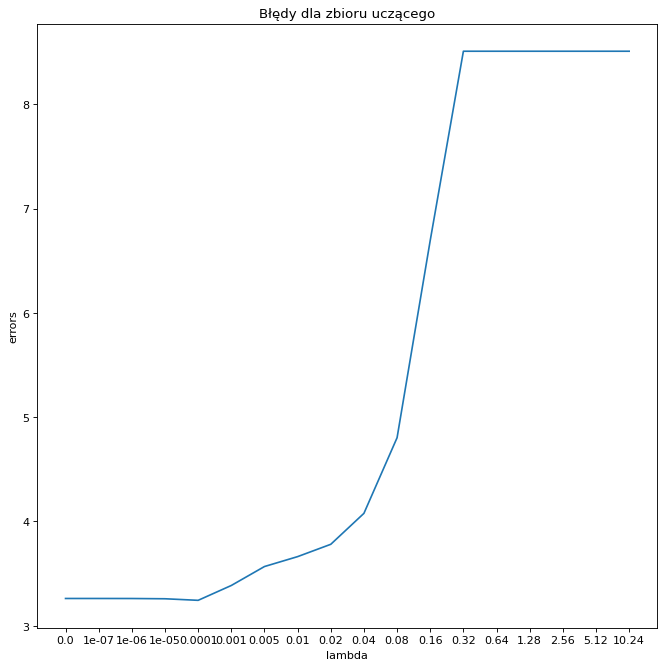

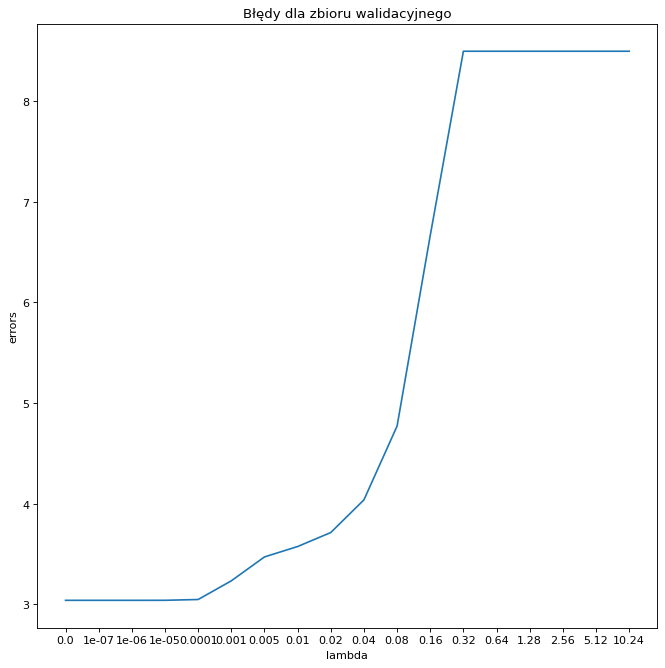

Best alpha: 0.0001
Test error: 2.92657810815379

{'value': -237.55193316452562, 'label': 'rt1/200-HIV/AIDS'}
{'value': -58.74716039171951, 'label': 'rt1/50-Population'}
{'value': 44.79205485135653, 'label': 'rt1/200-GDP'}
{'value': 28.32761321393041, 'label': 'rt1/4-thinness 5-9 years'}
{'value': -11.180805689326544, 'label': 'log_2-thinness 5-9 years'}
{'value': -10.216560045683371, 'label': 'rt1/200-Alcohol'}
{'value': 8.5324497713316, 'label': 'log_200-Status'}
{'value': 4.486696719775357, 'label': 'rt1/10-Population'}
{'value': 4.260125590080718, 'label': 'sqrt-Total expenditure'}
{'value': 2.9097736816683777, 'label': 'rt1/50-under_five_deaths_square'}


In [ ]:
perform_regularised_regression(linear_model.Lasso, data_train, life_expectancy_train, data_test, life_expectancy_test)

Najlepsze 𝜆 jest równe 0.0001. Potem błąd na zbiorze testowym zaczyna gwałtownie rosnąć. Przyjęcie takiej lamby powinno nieznacznie usprawnić model. Dla tej wartości parametru regularyzacji błąd na zbiorze testowym wynosi 2.92657810815379.

Najistotniejsze cechy: **HIV/AIDS**, Population, GDP, **thinness 5-9 years**, Alcohol

##### ***Metoda Grzbietowa*** 


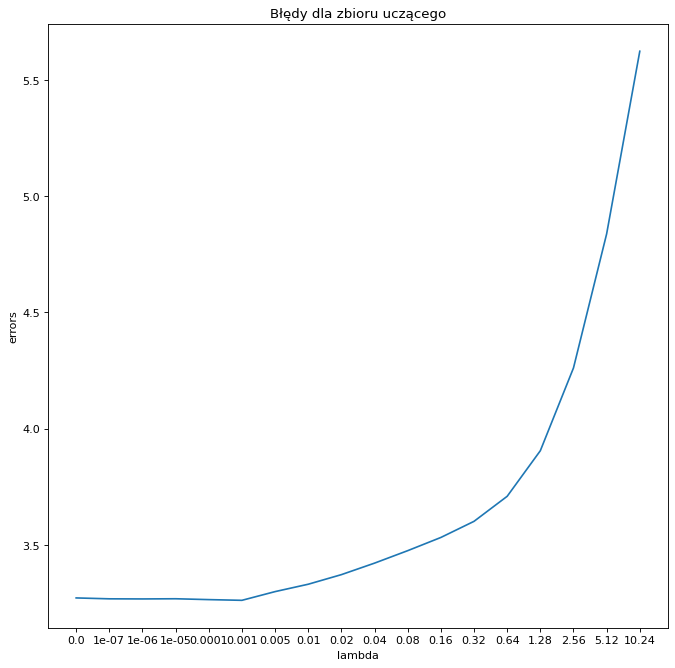

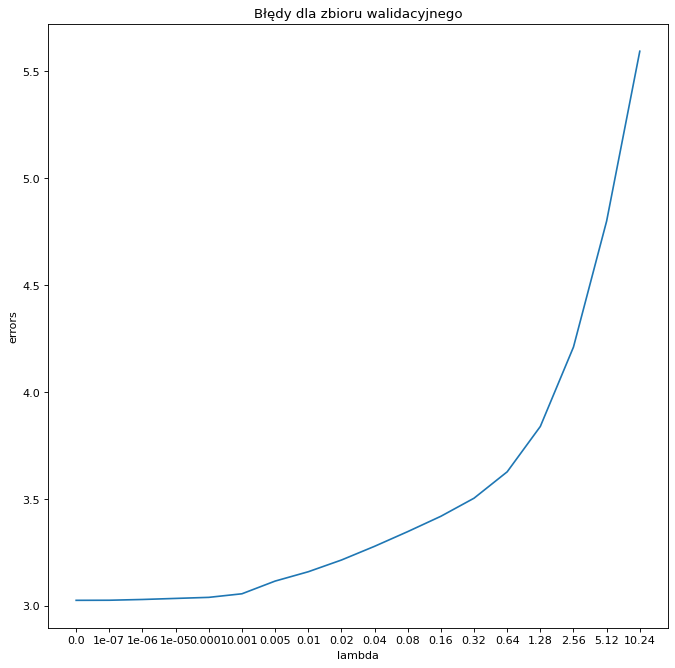

Best alpha: 0.001
Test error: 2.9279204665146326

{'value': -109.20486814837543, 'label': 'rt1/200-HIV/AIDS'}
{'value': -71.06822003215389, 'label': 'rt1/200-HIV_AIDS_square'}
{'value': -55.779687518520625, 'label': 'rt1/50-Population'}
{'value': 54.20362756940637, 'label': 'rt1/200-GDP'}
{'value': 20.78737353769323, 'label': 'rt1/4-thinness 5-9 years'}
{'value': -20.783167565786634, 'label': 'rt1/200-Alcohol'}
{'value': -8.512610550807219, 'label': 'log_2-thinness 5-9 years'}
{'value': 4.724152702369254, 'label': 'sqrt-Total expenditure'}
{'value': 4.292461647959729, 'label': 'rt1/10-Population'}
{'value': 3.0043378295660035, 'label': 'log_200-Status'}


In [ ]:
perform_regularised_regression(linear_model.Ridge, data_train, life_expectancy_train, data_test, life_expectancy_test)

Model grzbietowy będzie normalizowany celem możliwości porównania współczynników.

Możemy zauważyć lekkie rozbieżności między przebiegiem błędu walidacji i treningu. Ponieważ są one drobne, to  w dalszym ciągu uznamy 0.001 za najlepszą alfę. Błąd na zbiorze testowym wynosi 2.9279204665146326. 

Najistotniejsze współczynniki: **HIV/AIDS**. Population, GDP, **thinness 5-9 years**, Alcohol

#### Modele regresji


##### ***Regresja wielomianowa*** 


Przygotowanie danych — wybieramy 5 jako maksymalny stopień wielomianu.

In [ ]:
data_polynomial = data_cleaned.copy()

In [ ]:
MAX_DEGREE = 5

for degree, column in product(range(2, MAX_DEGREE + 1), data_polynomial):
  data_polynomial[f"(^{degree})-{column}"] = data_polynomial[column].apply(lambda x: x ** degree)

In [ ]:
poly_data_train, poly_data_test, poly_life_expectancy_train, poly_life_expectancy_test = train_test_split(data_polynomial, life_expectancy, test_size=0.33, random_state=RANDOM_STATE)

In [ ]:
data_polynomial.columns

Index(['Status', 'Adult Mortality', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure',
       ...
       '(^5)-rt1/4-thinness 5-9 years', '(^5)-log_2-thinness 5-9 years',
       '(^5)-sqrt-Schooling', '(^5)-rt1/50-under_five_deaths_square',
       '(^5)-rt1/10-under_five_deaths_square', '(^5)-rt1/200-HIV_AIDS_square',
       '(^5)-cbrt-percentage_expenditure_schooling',
       '(^5)-sqrt-percentage_expenditure_schooling',
       '(^5)-cbrt-cases_of_preventable_diseases',
       '(^5)-rt1/10-cases_of_preventable_diseases'],
      dtype='object', length=260)

##### ***Uczenie całego modelu*** 


In [ ]:
model = LinearRegression(normalize=True)
model.fit(poly_data_train, poly_life_expectancy_train)
train_results = model.predict(poly_data_train)
test_results = model.predict(poly_data_test)

print(f"Train error: {sqrt(mean_squared_error(train_results, poly_life_expectancy_train))}")
print(f"Test error: {sqrt(mean_squared_error(test_results, poly_life_expectancy_test))}\n")

coefficients = get_sorted_coefficients(model)
coefficients[0: 60]

Train error: 2.137489656005149
Test error: 3.0082784995549448



[{'label': '(^5)-log_200-Status', 'value': -1.3921645145268456e+17},
 {'label': '(^4)-log_200-Status', 'value': -1.821283309812843e+16},
 {'label': '(^3)-log_200-Status', 'value': -2578046215412585.5},
 {'label': '(^2)-log_200-Status', 'value': -335734983626819.06},
 {'label': 'rt1/200-HIV/AIDS', 'value': -297582435068457.1},
 {'label': '(^2)-rt1/200-HIV/AIDS', 'value': 217370431669380.53},
 {'label': 'rt1/200-HIV_AIDS_square', 'value': 202013108365855.7},
 {'label': '(^3)-rt1/200-Alcohol', 'value': -179932023796412.78},
 {'label': '(^2)-rt1/200-Alcohol', 'value': 174566380496672.56},
 {'label': '(^4)-rt1/200-HIV/AIDS', 'value': -131779694913915.23},
 {'label': '(^3)-rt1/200-HIV_AIDS_square', 'value': 124346416642298.12},
 {'label': '(^3)-rt1/200-HIV/AIDS', 'value': -124278437990976.27},
 {'label': '(^2)-rt1/200-GDP', 'value': -100187078259871.34},
 {'label': '(^4)-rt1/200-Alcohol', 'value': 92744447512687.9},
 {'label': 'rt1/200-Alcohol', 'value': -84692164747934.44},
 {'label': 'Stat

Na zbiorze testowym uzyskaliśmy błąd 3.0082784995549448, a na treningowym 2.137489656005149 - lepszy w porównaniu do poprzednich modeli regresyjnych  


Najistotniejsze cechy: Status, __HIV/AIDS__, Alcohol, GDP, under-five deaths, __Schooling__, cases_of_preventable_diseases​

##### ***Regresja krokowa w przód***





In [ ]:
def perform_forward_regression(n, train_data, train_results, test_data, test_results):
  outcome = []
  all_features = train_data.columns.tolist()
  best_features = []
  for i in range(n):
    best_to_add = None
    current_best_score = float("inf")

    for feature in all_features:
      best_features.append(feature)

      model = LinearRegression(normalize=True)
      model.fit(poly_data_train[best_features], poly_life_expectancy_train)
      train_results = model.predict(poly_data_train[best_features])
      train_error = sqrt(mean_squared_error(train_results, poly_life_expectancy_train))

      if train_error < current_best_score:
        current_best_score = train_error
        best_to_add = feature

      best_features.pop()

    best_features.append(best_to_add)

    model = LinearRegression(normalize=True)
    model.fit(poly_data_train[best_features], poly_life_expectancy_train)
    train_results = model.predict(poly_data_train[best_features])
    test_results = model.predict(poly_data_test[best_features])
    train_error = sqrt(mean_squared_error(train_results, poly_life_expectancy_train))
    test_error = sqrt(mean_squared_error(test_results, poly_life_expectancy_test))

    outcome.append({
        "features": best_features.copy(),
        "train_error": train_error,
        "test_error": test_error
    })
    all_features.remove(best_to_add)

  return outcome

In [ ]:
outcomes_of_forward = perform_forward_regression(10, poly_data_train, poly_life_expectancy_train, poly_data_test, poly_life_expectancy_test)

for outcome in outcomes_of_forward:
  print(outcome["features"])

['(^5)-rt1/200-HIV_AIDS_square']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles', 'GDP']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles', 'GDP', 'sqrt-Adult Mortality']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles', 'GDP', 'sqrt-Adult Mortality', '(^5)-sqrt-Adult Mortality']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles', 'GDP', 'sqrt-Adult Mortality', '(^5)-sqrt-Adult Mortality', 'HIV/AIDS']
['(^5)-rt1/200-HIV_AIDS_square', '(^3)-sqrt-Schooling', '(^3)-sqrt-Adult Mortality', 'rt1/10-Measles', 'GDP', 'sqrt-Adult Mortality', '(^5)-s

Najistotniejsze cechy obrane przez tę metodę: __HIV/AIDS__, __Schooling__, Adult Mortality, Measles, Alcohol, under-five deaths

##### ***Metoda Grzbietowa i Lasso***

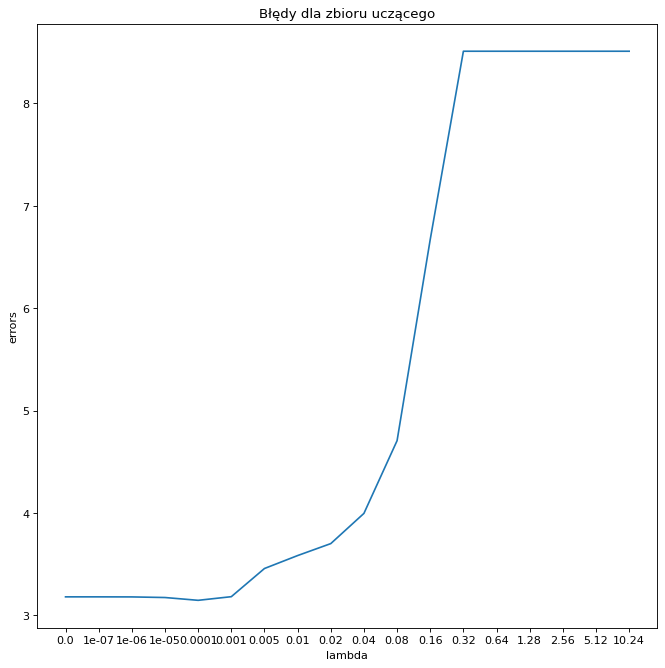

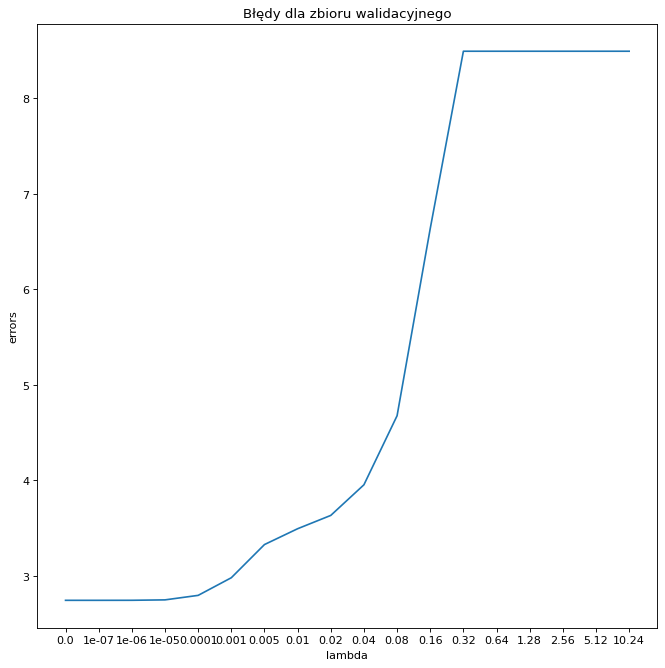

Best alpha: 0.0001
Test error: 2.730687517134244

{'value': -134.921891506824, 'label': 'rt1/200-HIV/AIDS'}
{'value': 39.12077512652815, 'label': 'rt1/200-GDP'}
{'value': -27.0296050756577, 'label': 'rt1/200-HIV_AIDS_square'}
{'value': 10.194948460505142, 'label': 'log_200-Status'}
{'value': -8.613850146465177, 'label': 'rt1/50-Population'}
{'value': -8.116816779416277, 'label': '(^5)-cases_of_preventable_diseases'}
{'value': 7.599761458889409, 'label': '(^2)-cases_of_preventable_diseases'}
{'value': 6.347213787235194, 'label': 'rt1/4-thinness 5-9 years'}
{'value': -5.065474262766277, 'label': 'sqrt-Schooling'}
{'value': -4.099178187486998, 'label': 'log_2-thinness 5-9 years'}


In [ ]:
perform_regularised_regression(linear_model.Lasso, poly_data_train, poly_life_expectancy_train, poly_data_test, poly_life_expectancy_test)

Widzimy, że obranie drobnej lambdy powinno usprawniać jakość modelu. Dodtakowo warto zauważyć jego wyższość nad modelami nie-wielomianowymi.

Najistotniejsze cechy: __HIV/AIDS__, GDP, Status, Population, cases-of-preventable-diseases, __Schooling__, __thinness 5-9 years​__

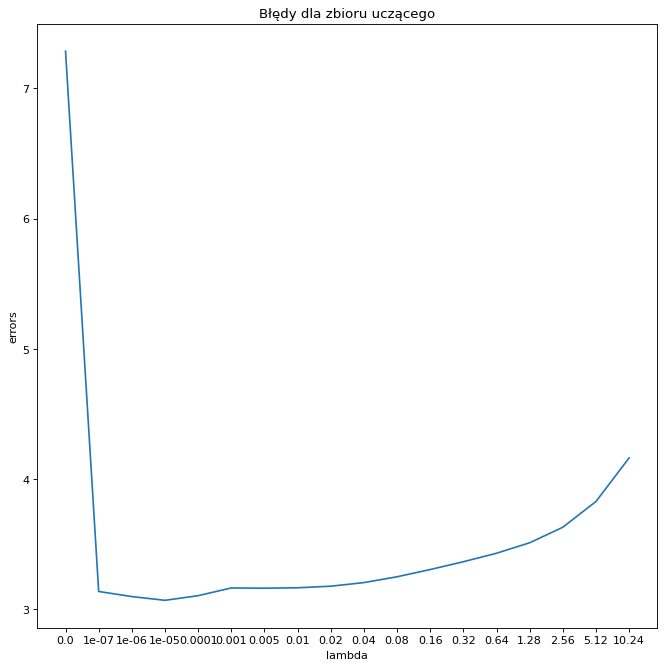

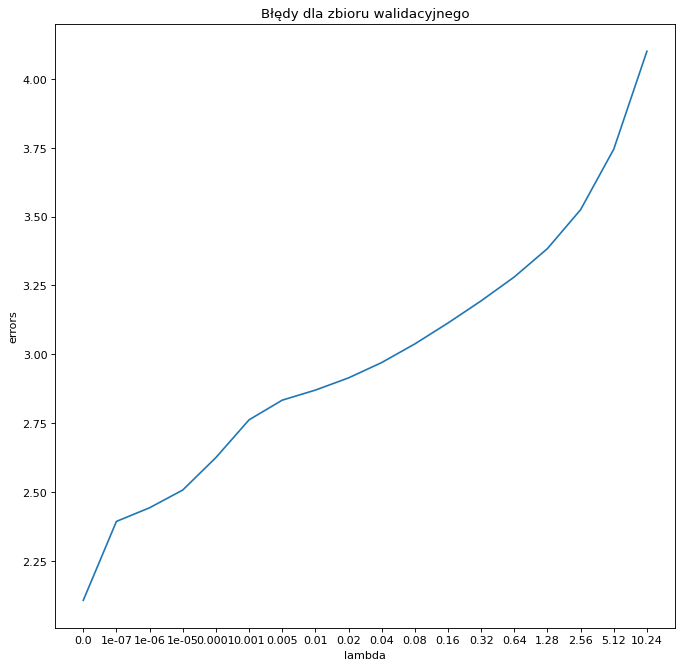

Best alpha: 1e-05
Test error: 2.685280442456662

{'value': 2931.057067588999, 'label': '(^5)-log_200-Status'}
{'value': 953.3331088915979, 'label': 'rt1/200-HIV/AIDS'}
{'value': -551.2445944685691, 'label': 'rt1/200-GDP'}
{'value': 383.45267037129554, 'label': '(^4)-log_200-Status'}
{'value': 333.09014724631754, 'label': '(^2)-rt1/200-HIV/AIDS'}
{'value': 333.09014694151114, 'label': 'rt1/200-HIV_AIDS_square'}
{'value': -179.59570766911204, 'label': '(^2)-rt1/200-GDP'}
{'value': -172.43767091763328, 'label': 'rt1/50-Population'}
{'value': -167.86783146944128, 'label': '(^4)-cases_of_preventable_diseases'}
{'value': -167.4164851589694, 'label': 'rt1/200-Alcohol'}


In [ ]:
perform_regularised_regression(linear_model.Ridge, poly_data_train, poly_life_expectancy_train, poly_data_test, poly_life_expectancy_test)

Widzimy, że dla metody grzbietowej występuje lekkie przeuczenie (różnice wahają się w okolicy wielkości 2; jest to względnie mało, choć tendencja jest ewidentna i rosnąca).  

Najistotniejsze cechy: Status, __HIV/AIDS__, GDP, Population, cases-of-preventable-diseases, Alcohol​

#### Wnioski 


##### Ocena modeli


*   Modele bardziej złożone pozwalały nam na redukcję błędów. Użycie metod regularyzacji miało najczęściej niewielki, ale owocny wpływ na ich jakość (z wyłączeniem regresji wielomianowej lasso i ridge)
*   Najmniejszy błąd na zbiorze testowym udało się nam uzyskać dla regresji Ridge i wynosi on 2.685280442456662. 
*   Błąd w metodzie Lasso był większy od Ridge. Metoda Ridge lepiej sprawdza się gdy większość cech jest użytecznych, a tak było w tym przypadku.
*   Biorąc pod uwagę, że średnia wieku wynosi 68 lat to błąd na poziomie ok. 2.69 jest mały.












##### **Weryfikacja tezy badawczej**


Dla metody Ridge, która dała nam najmniejszy błąd na zbiorze testowym, wśród cech o najwyższych współczynnikach były HIV/AIDS i dodana przez nas cecha HIV/AIDS_square, która wzmacnia znaczenie tego atrybutu. Potwierdziło się, że HIV_AIDS jest znaczącą cechą. Przez metodę Lasso, która generowała błąd o -0.04540707467758187 mniejszy zostało wybrane m.in.Schooling co również jest zgodne z przewidywaniami postawionymi w tezie. Wbrew naszym oczekiwaniom BMI nie zostało uznawane przez nasze modele jako znacząca cecha. 
Tezę badawczą uznajemy za w większości potwierdzoną.